In [ ]:

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/ffhq-face-data-set/thumbnails128x128/64284.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/27147.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/52235.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/32352.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/41695.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/21130.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/36145.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/67419.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/22897.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/60077.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/18966.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/22069.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/47434.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/52691.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/32860.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/37825.png
/kaggle/input/ffhq-face-

In [3]:
!pip install Cython

In [4]:
import torch

In [5]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline

In [6]:
import sys
import torch
from torch.utils.data import dataloader
from torch.multiprocessing import reductions
from multiprocessing.reduction import ForkingPickler

default_collate_func = dataloader.default_collate


def default_collate_override(batch):
    dataloader._use_shared_memory = False
    return default_collate_func(batch)

setattr(dataloader, 'default_collate', default_collate_override)

for t in torch._storage_classes:
    if sys.version_info[0] == 2:
        if t in ForkingPickler.dispatch:
            del ForkingPickler.dispatch[t]
    else:
        if t in ForkingPickler._extra_reducers:
            del ForkingPickler._extra_reducers[t]

In [7]:

class ScaleW:
    '''
    Constructor: name - name of attribute to be scaled
    '''
    def __init__(self, name):
        self.name = name
    
    def scale(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        
        return weight * math.sqrt(2 / fan_in)
    
    @staticmethod
    def apply(module, name):
        '''
        Apply runtime scaling to specific module
        '''
        hook = ScaleW(name)
        weight = getattr(module, name)
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        del module._parameters[name]
        module.register_forward_pre_hook(hook)
    
    def __call__(self, module, whatever):
        weight = self.scale(module)
        setattr(module, self.name, weight)

# Quick apply for scaled weight
def quick_scale(module, name='weight'):
    ScaleW.apply(module, name)
    return module

# Uniformly set the hyperparameters of Linears

class SLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()

        linear = nn.Linear(dim_in, dim_out)
        linear.weight.data.normal_()
        linear.bias.data.zero_()
        
        self.linear = quick_scale(linear)

    def forward(self, x):
        return self.linear(x)

# Uniformly set the hyperparameters of Conv2d

class SConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        
        self.conv = quick_scale(conv)

    def forward(self, x):
        return self.conv(x)

# Normalization on every element of input vector
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

# "learned affine transform" A
class FC_A(nn.Module):
    '''
    Learned affine transform A, this module is used to transform
    midiate vector w into a style vector
    '''
    def __init__(self, dim_latent, n_channel):
        super().__init__()
        self.transform = SLinear(dim_latent, n_channel * 2)
        # "the biases associated with ys that we initialize to one"
        self.transform.linear.bias.data[:n_channel] = 1
        self.transform.linear.bias.data[n_channel:] = 0

    def forward(self, w):
        # Gain scale factor and bias with:
        style = self.transform(w).unsqueeze(2).unsqueeze(3)
        return style
    
# AdaIn (AdaptiveInstanceNorm)
class AdaIn(nn.Module):
    '''
    adaptive instance normalization
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.norm = nn.InstanceNorm2d(n_channel)
        
    def forward(self, image, style):
        factor, bias = style.chunk(2, 1)
        result = self.norm(image)
        result = result * factor + bias  
        return result

# "learned per-channel scaling factors" B

class Scale_B(nn.Module):
    '''
    Learned per-channel scale factor, used to scale the noise
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((1, n_channel, 1, 1)))
    
    def forward(self, noise):
        result = noise * self.weight
        return result 

# Early convolutional block

class Early_StyleConv_Block(nn.Module):
    '''
    This is the very first block of generator that get the constant value as input
    '''
    def __init__ (self, n_channel, dim_latent, dim_input):
        super().__init__()
        # Constant input
        self.constant = nn.Parameter(torch.randn(1, n_channel, dim_input, dim_input))
        # Style generators
        self.style1   = FC_A(dim_latent, n_channel)
        self.style2   = FC_A(dim_latent, n_channel)
        # Noise processing modules
        self.noise1   = quick_scale(Scale_B(n_channel))
        self.noise2   = quick_scale(Scale_B(n_channel))
        # AdaIn
        self.adain    = AdaIn(n_channel)
        self.lrelu    = nn.LeakyReLU(0.2)
        # Convolutional layer
        self.conv     = SConv2d(n_channel, n_channel, 3, padding=1)
    
    def forward(self, latent_w, noise):
        # Gaussian Noise: Proxyed by generator
        # noise1 = torch.normal(mean=0,std=torch.ones(self.constant.shape)).cuda()
        # noise2 = torch.normal(mean=0,std=torch.ones(self.constant.shape)).cuda()
        result = self.constant.repeat(noise.shape[0], 1, 1, 1)
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result
    
# General convolutional blocks
class StyleConv_Block(nn.Module):
    '''
    This is the general class of style-based convolutional blocks
    '''
    def __init__ (self, in_channel, out_channel, dim_latent):
        super().__init__()
        # Style generators
        self.style1   = FC_A(dim_latent, out_channel)
        self.style2   = FC_A(dim_latent, out_channel)
        # Noise processing modules
        self.noise1   = quick_scale(Scale_B(out_channel))
        self.noise2   = quick_scale(Scale_B(out_channel))
        # AdaIn
        self.adain    = AdaIn(out_channel)
        self.lrelu    = nn.LeakyReLU(0.2)
        # Convolutional layers
        self.conv1    = SConv2d(in_channel, out_channel, 3, padding=1)
        self.conv2    = SConv2d(out_channel, out_channel, 3, padding=1)
    
    def forward(self, previous_result, latent_w, noise):
        # Upsample: Proxyed by generator
        # result = nn.functional.interpolate(previous_result, scale_factor=2, mode='bilinear',
        #                                           align_corners=False)
        # Conv 3*3
        result = self.conv1(previous_result)
        # Gaussian Noise: Proxyed by generator
        # noise1 = torch.normal(mean=0,std=torch.ones(result.shape)).cuda()
        # noise2 = torch.normal(mean=0,std=torch.ones(result.shape)).cuda()
        # Conv & Norm
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv2(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result    

# Very First Convolutional Block
class ConvBlock(nn.Module):
    '''
    Used to construct progressive discriminator
    '''
    def __init__(self, in_channel, out_channel, size_kernel1, padding1, 
                 size_kernel2 = None, padding2 = None):
        super().__init__()
        
        if size_kernel2 == None:
            size_kernel2 = size_kernel1
        if padding2 == None:
            padding2 = padding1
        
        self.conv = nn.Sequential(
            SConv2d(in_channel, out_channel, size_kernel1, padding=padding1),
            nn.LeakyReLU(0.2),
            SConv2d(out_channel, out_channel, size_kernel2, padding=padding2),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, image):
        # Downsample now proxyed by discriminator
        # result = nn.functional.interpolate(image, scale_factor=0.5, mode="bilinear", align_corners=False)
        # Conv
        result = self.conv(image)
        return result
        
    
# Main components
class Intermediate_Generator(nn.Module):
    '''
    A mapping consists of multiple fully connected layers.
    Used to map the input to an intermediate latent space W.
    '''
    def __init__(self, n_fc, dim_latent):
        super().__init__()
        layers = [PixelNorm()]
        for i in range(n_fc):
            layers.append(SLinear(dim_latent, dim_latent))
            layers.append(nn.LeakyReLU(0.2))
            
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, latent_z):
        latent_w = self.mapping(latent_z)
        return latent_w    

# Generator

class StyleBased_Generator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self, n_fc, dim_latent, dim_input):
        super().__init__()
        # Waiting to adjust the size
        self.fcs    = Intermediate_Generator(n_fc, dim_latent)
        self.convs  = nn.ModuleList([
            Early_StyleConv_Block(512, dim_latent, dim_input),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 256, dim_latent),
            StyleConv_Block(256, 128, dim_latent),
            StyleConv_Block(128, 64, dim_latent),
            StyleConv_Block(64, 32, dim_latent),
            StyleConv_Block(32, 16, dim_latent)
        ])
        self.to_rgbs = nn.ModuleList([
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(256, 3, 1),
            SConv2d(128, 3, 1),
            SConv2d(64, 3, 1),
            SConv2d(32, 3, 1),
            SConv2d(16, 3, 1)
        ])
    def forward(self, latent_z, 
                step = 0,  # Step means how many layers (count from 4 x 4) are used to train
                alpha=-1,  # Alpha is the parameter of smooth conversion of resolution):
                noise=None,     # TODO: support input noise
                mix_steps=[]):     # steps inside will use latent_z[1], else latent_z[0]
        if type(latent_z) != type([]):
            print('You should use list to package your latent_z')
            latent_z = [latent_z]
        if (len(latent_z) != 2 and len(mix_steps) > 0) or type(mix_steps) != type([]):
            print('Warning: Style mixing disabled, possible reasons:')
            print('- Invalid number of latent vectors')
            print('- Invalid parameter type: mix_steps')
            mix_steps = []
        
        latent_w = [self.fcs(latent) for latent in latent_z]
        batch_size = latent_w[0].size(0)
        
        # Generate needed Gaussian noise
   
        result = 0
        current_latent = 0

        for i, conv in enumerate(self.convs):
            # Choose current latent_w
            if i in mix_steps:
                current_latent = latent_w[1]
            else:
                current_latent = latent_w[0]
                
            # Not the first layer, need to upsample
            if i > 0 and step > 0:
                result_upsample = nn.functional.interpolate(result, scale_factor=2, mode='bilinear',
                                                  align_corners=False)
                result = conv(result_upsample, current_latent, noise[i])
            else:
                result = conv(current_latent, noise[i])
            
            # Final layer, output rgb image
            if i == step:
                result = self.to_rgbs[i](result)
                
                if i > 0 and 0 <= alpha < 1:
                    result_prev = self.to_rgbs[i - 1](result_upsample)
                    result = alpha * result + (1 - alpha) * result_prev
                    
                # Finish and break
                break
        
        return result

# Discriminator

class Discriminator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self):
        super().__init__()
        # Waiting to adjust the size
        self.from_rgbs = nn.ModuleList([
            SConv2d(3, 16, 1),
            SConv2d(3, 32, 1),
            SConv2d(3, 64, 1),
            SConv2d(3, 128, 1),
            SConv2d(3, 256, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1)
       ])
        self.convs  = nn.ModuleList([
            ConvBlock(16, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(513, 512, 3, 1, 4, 0)
        ])
        self.fc = SLinear(512, 1)
        
        self.n_layer = 9 # 9 layers network
    
    def forward(self, image, 
                step = 0,  # Step means how many layers (count from 4 x 4) are used to train
                alpha=-1):  # Alpha is the parameter of smooth conversion of resolution):
        for i in range(step, -1, -1):
            # Get the index of current layer
            # Count from the bottom layer (4 * 4)
            layer_index = self.n_layer - i - 1 
            
            # First layer, need to use from_rgb to convert to n_channel data
            if i == step: 
                result = self.from_rgbs[layer_index](image)
            
            # Before final layer, do minibatch stddev
            if i == 0:
                # In dim: [batch, channel(512), 4, 4]
                res_var = result.var(0, unbiased=False) + 1e-8 # Avoid zero
                # Out dim: [channel(512), 4, 4]
                res_std = torch.sqrt(res_var)
                # Out dim: [channel(512), 4, 4]
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                # Out dim: [1] -> [batch, 1, 4, 4]
                result = torch.cat([result, mean_std], 1)
                # Out dim: [batch, 512 + 1, 4, 4]
            
            # Conv
            result = self.convs[layer_index](result)
            
            # Not the final layer
            if i > 0:
                # Downsample for further usage
                result = nn.functional.interpolate(result, scale_factor=0.5, mode='bilinear',
                                                  align_corners=False)
                # Alpha set, combine the result of different layers when input
                if i == step and 0 <= alpha < 1:
                    result_next = self.from_rgbs[layer_index + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5,
                                                           mode = 'bilinear', align_corners=False)
                
                    result = alpha * result + (1 - alpha) * result_next
                    

        result = result.squeeze(2).squeeze(2)
        result = self.fc(result)
        return result

No pre-trained model detected, restart training...


Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0416:   0%|          | 39/599999 [00:47<145:22:12,  1.15it/s]

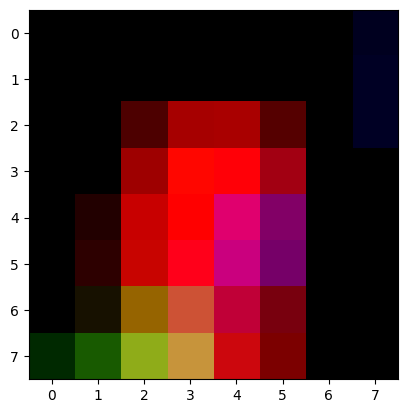

Resolution: 8*8  D_Loss: 0.4097  G_Loss: 4.7892  Alpha: 0.0843:   0%|          | 79/599999 [01:22<146:44:12,  1.14it/s]

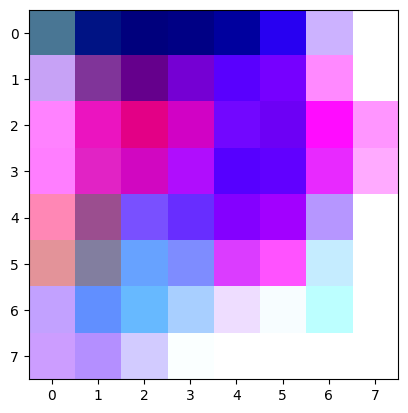

Resolution: 8*8  D_Loss: 0.0926  G_Loss: 7.1572  Alpha: 0.1269:   0%|          | 119/599999 [01:58<149:16:49,  1.12it/s]

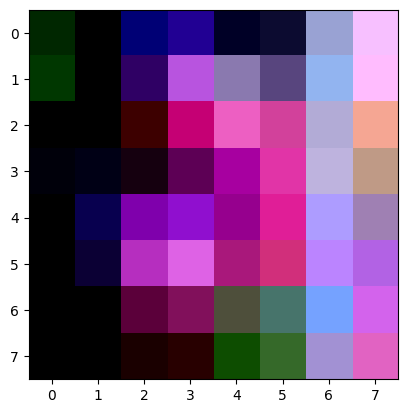

Resolution: 8*8  D_Loss: 0.0482  G_Loss: 10.5467  Alpha: 0.1696:   0%|          | 159/599999 [02:34<150:36:29,  1.11it/s]

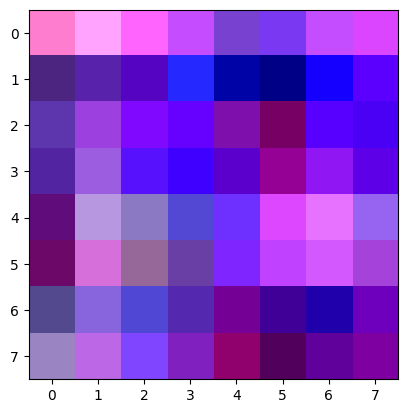

Resolution: 8*8  D_Loss: 0.0350  G_Loss: 12.3950  Alpha: 0.2123:   0%|          | 199/599999 [03:11<152:08:33,  1.10it/s]

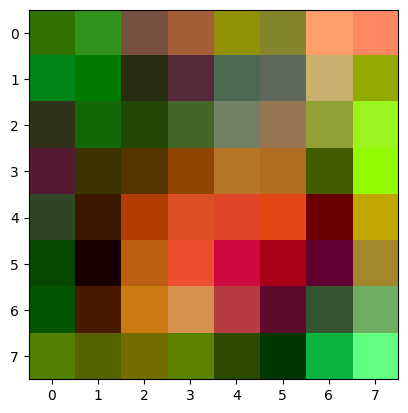

Resolution: 8*8  D_Loss: 0.0559  G_Loss: 12.8530  Alpha: 0.2549:   0%|          | 239/599999 [03:48<151:56:50,  1.10it/s]

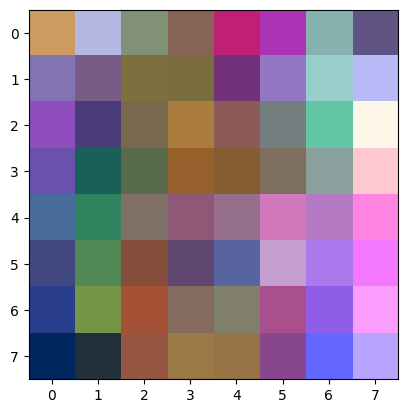

Resolution: 8*8  D_Loss: 0.1190  G_Loss: 10.7667  Alpha: 0.2976:   0%|          | 279/599999 [04:26<173:37:32,  1.04s/it]

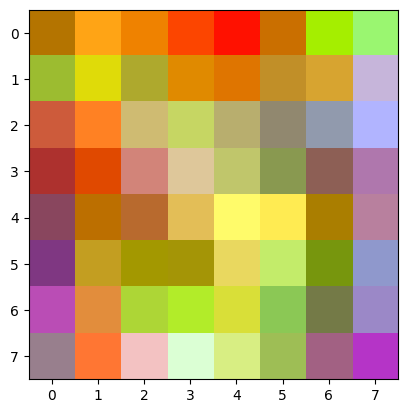

Resolution: 8*8  D_Loss: 0.1548  G_Loss: 9.6199  Alpha: 0.3403:   0%|          | 319/599999 [05:03<152:01:03,  1.10it/s] 

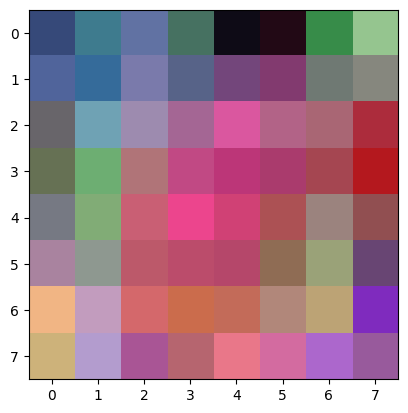

Resolution: 8*8  D_Loss: 0.0764  G_Loss: 10.4810  Alpha: 0.3829:   0%|          | 359/599999 [05:39<151:26:09,  1.10it/s]

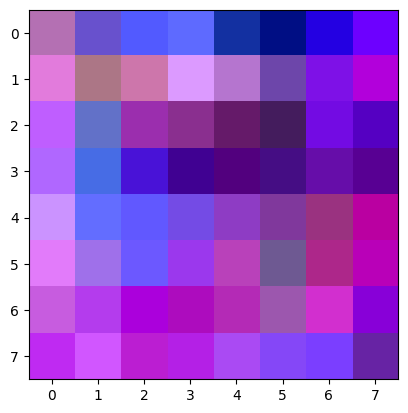

Resolution: 8*8  D_Loss: 0.0639  G_Loss: 8.5660  Alpha: 0.4256:   0%|          | 399/599999 [06:16<151:58:22,  1.10it/s] 

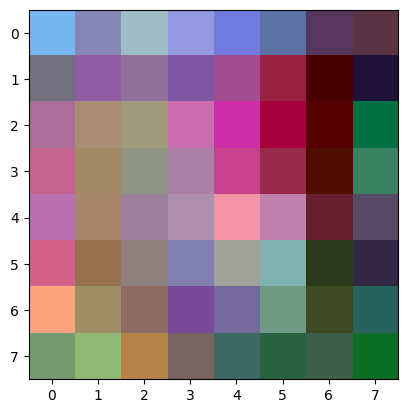

Resolution: 8*8  D_Loss: 0.0445  G_Loss: 7.3101  Alpha: 0.4683:   0%|          | 439/599999 [06:53<151:32:01,  1.10it/s]

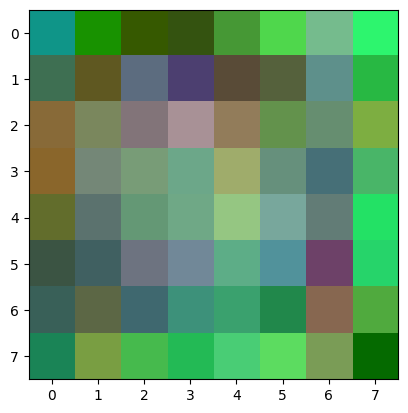

Resolution: 8*8  D_Loss: 0.2330  G_Loss: 6.6388  Alpha: 0.5109:   0%|          | 479/599999 [07:29<152:17:55,  1.09it/s]

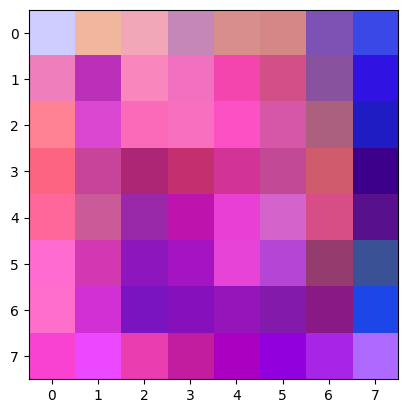

Resolution: 8*8  D_Loss: 0.0415  G_Loss: 10.6390  Alpha: 0.5536:   0%|          | 519/599999 [08:06<151:27:11,  1.10it/s]

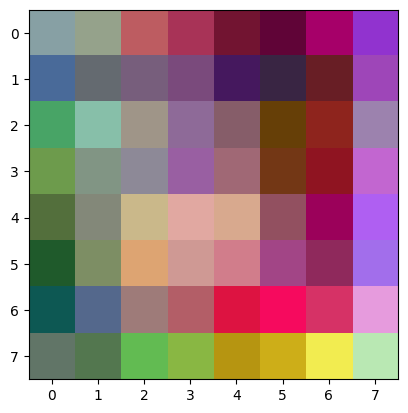

Resolution: 8*8  D_Loss: 0.1438  G_Loss: 6.4100  Alpha: 0.5963:   0%|          | 559/599999 [08:45<154:47:28,  1.08it/s] 

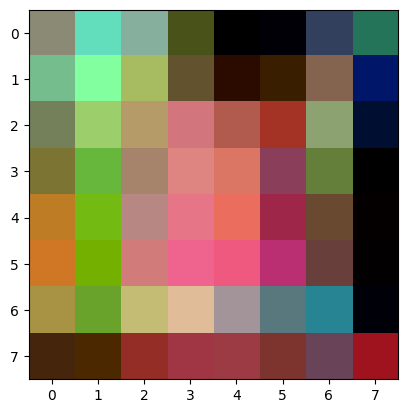

Resolution: 8*8  D_Loss: 0.0711  G_Loss: 9.9989  Alpha: 0.6389:   0%|          | 599/599999 [09:21<152:05:52,  1.09it/s]

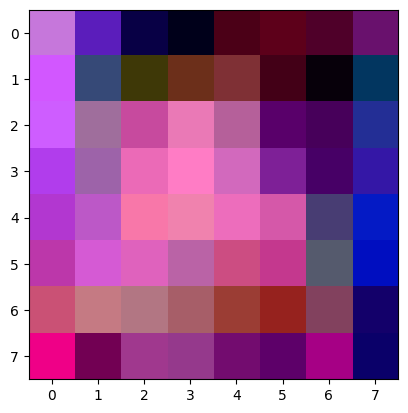

Resolution: 8*8  D_Loss: 0.0428  G_Loss: 10.3385  Alpha: 0.6816:   0%|          | 639/599999 [09:58<151:53:10,  1.10it/s]

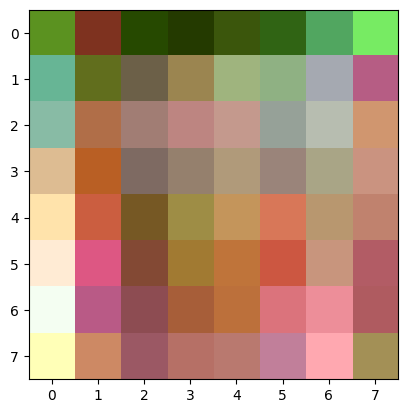

Resolution: 8*8  D_Loss: 0.0456  G_Loss: 7.6561  Alpha: 0.7243:   0%|          | 679/599999 [10:35<151:27:26,  1.10it/s] 

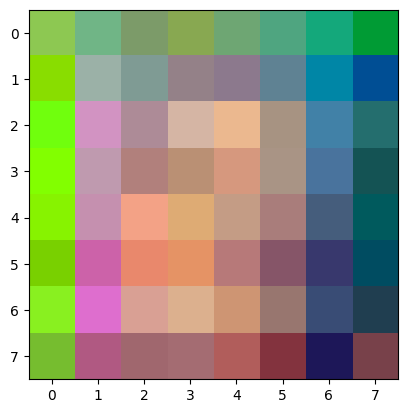

Resolution: 8*8  D_Loss: 0.0516  G_Loss: 8.7906  Alpha: 0.7669:   0%|          | 719/599999 [11:11<152:12:34,  1.09it/s]

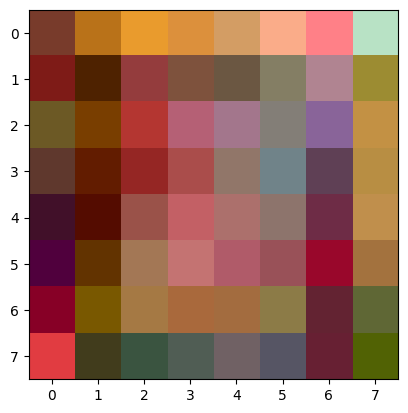

Resolution: 8*8  D_Loss: 0.0653  G_Loss: 8.1339  Alpha: 0.8096:   0%|          | 759/599999 [11:48<151:42:38,  1.10it/s]

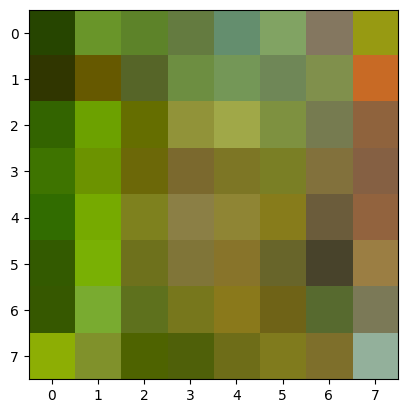

Resolution: 8*8  D_Loss: 0.0541  G_Loss: 8.6375  Alpha: 0.8523:   0%|          | 799/599999 [12:25<151:53:14,  1.10it/s]

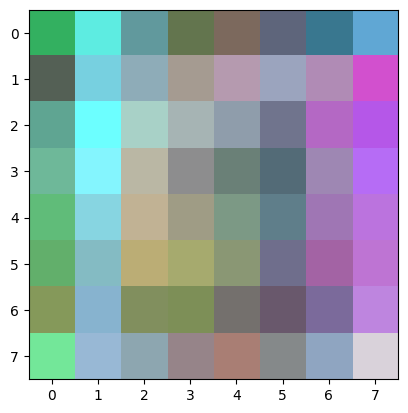

Resolution: 8*8  D_Loss: 0.1310  G_Loss: 7.4030  Alpha: 0.8949:   0%|          | 839/599999 [13:03<152:06:02,  1.09it/s]

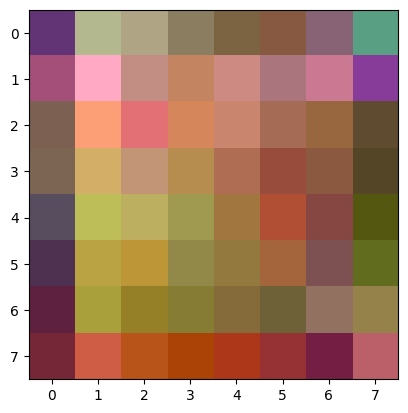

Resolution: 8*8  D_Loss: 0.0198  G_Loss: 8.1269  Alpha: 0.9376:   0%|          | 879/599999 [13:40<152:10:17,  1.09it/s]

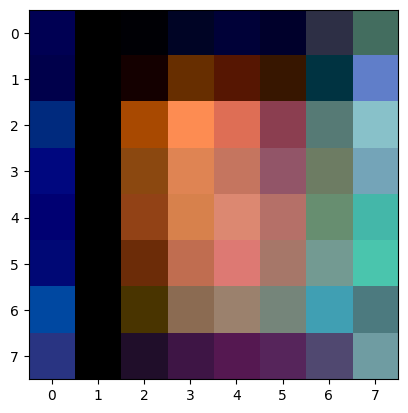

Resolution: 8*8  D_Loss: 0.0563  G_Loss: 7.9224  Alpha: 0.9803:   0%|          | 919/599999 [14:17<151:25:21,  1.10it/s]

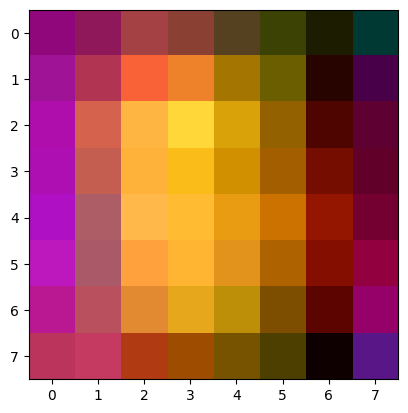

Resolution: 16*16  D_Loss: 0.0795  G_Loss: 10.2921  Alpha: 0.0096:   0%|          | 959/599999 [15:05<250:37:31,  1.51s/it]

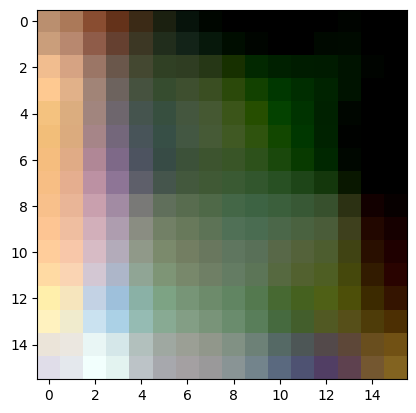

Resolution: 16*16  D_Loss: 0.2064  G_Loss: 5.7189  Alpha: 0.0309:   0%|          | 999/599999 [16:07<327:41:22,  1.97s/it] 

Iteration 999 successfully saved.


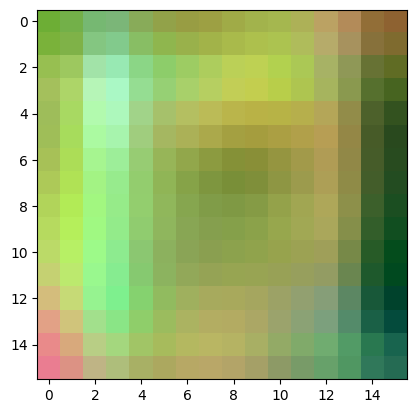

Resolution: 16*16  D_Loss: 0.2037  G_Loss: 7.4176  Alpha: 0.0523:   0%|          | 1039/599999 [17:06<249:53:50,  1.50s/it]

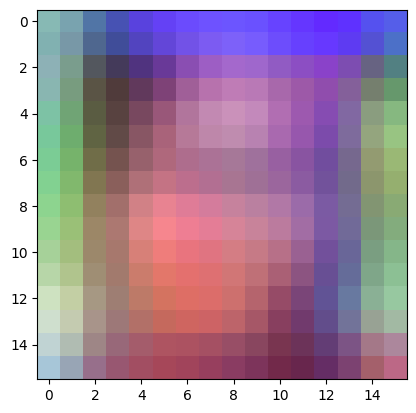

Resolution: 16*16  D_Loss: 0.2235  G_Loss: 4.5525  Alpha: 0.0736:   0%|          | 1079/599999 [18:07<249:45:22,  1.50s/it]

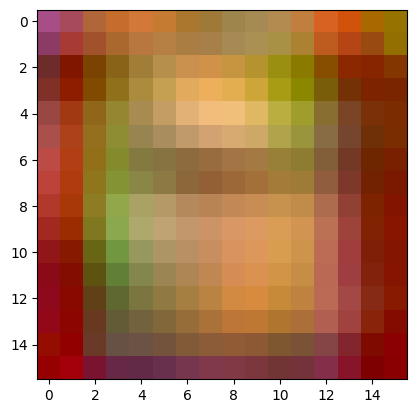

Resolution: 16*16  D_Loss: 0.1467  G_Loss: 5.7342  Alpha: 0.0949:   0%|          | 1119/599999 [19:07<251:01:25,  1.51s/it]

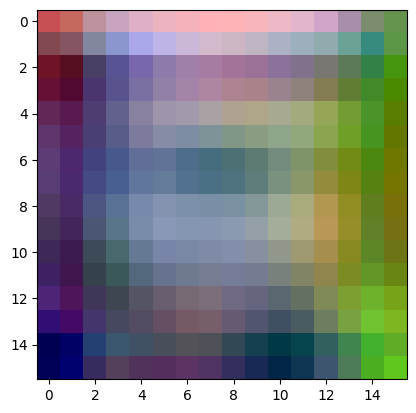

Resolution: 16*16  D_Loss: 0.1429  G_Loss: 5.9405  Alpha: 0.1163:   0%|          | 1159/599999 [20:07<249:41:36,  1.50s/it]

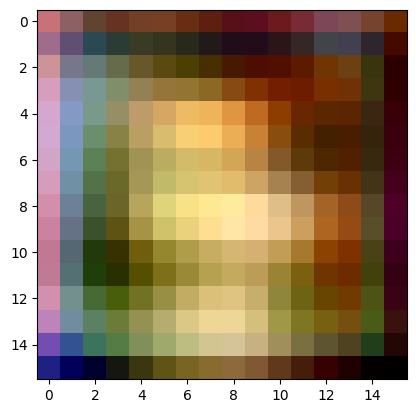

Resolution: 16*16  D_Loss: 0.0946  G_Loss: 5.7626  Alpha: 0.1376:   0%|          | 1199/599999 [21:07<250:12:24,  1.50s/it]

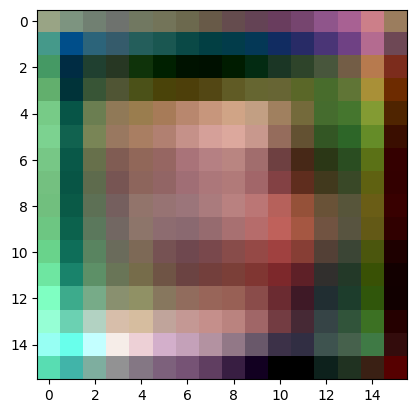

Resolution: 16*16  D_Loss: 1.1357  G_Loss: 12.6717  Alpha: 0.1589:   0%|          | 1239/599999 [22:08<249:24:58,  1.50s/it]

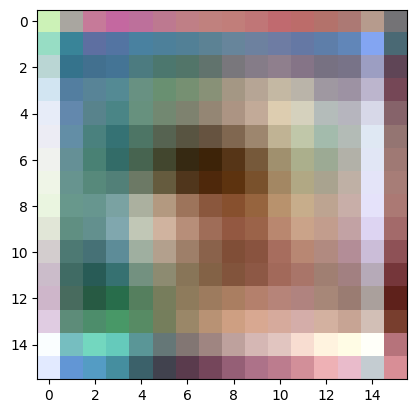

Resolution: 16*16  D_Loss: 0.1573  G_Loss: 5.3270  Alpha: 0.1803:   0%|          | 1279/599999 [23:08<249:40:36,  1.50s/it] 

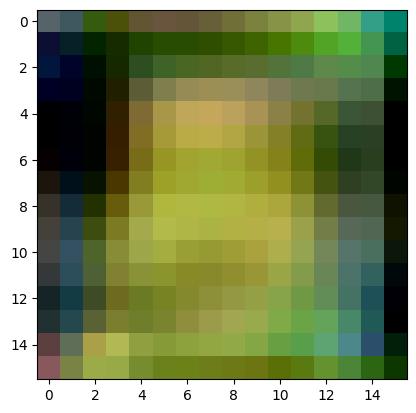

Resolution: 16*16  D_Loss: 0.1373  G_Loss: 4.2058  Alpha: 0.2016:   0%|          | 1319/599999 [24:08<250:03:29,  1.50s/it]

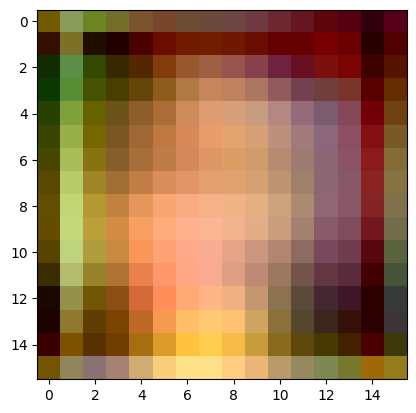

Resolution: 16*16  D_Loss: 0.1365  G_Loss: 4.8636  Alpha: 0.2229:   0%|          | 1359/599999 [25:09<250:19:19,  1.51s/it]

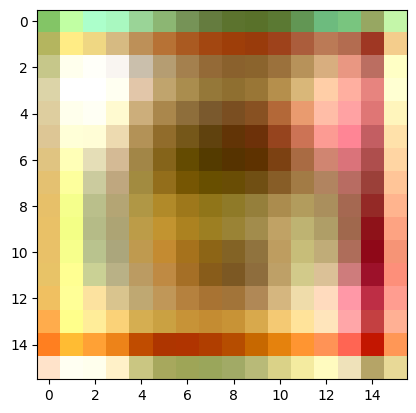

Resolution: 16*16  D_Loss: 0.1392  G_Loss: 4.8966  Alpha: 0.2443:   0%|          | 1399/599999 [26:09<250:24:23,  1.51s/it]

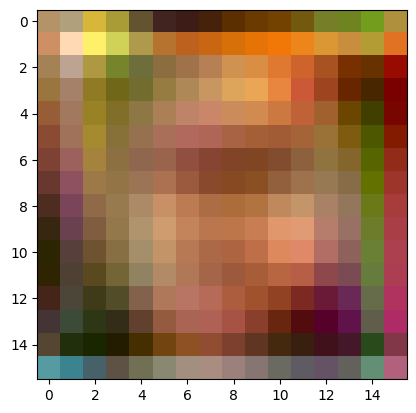

Resolution: 16*16  D_Loss: 0.2648  G_Loss: 5.4576  Alpha: 0.2656:   0%|          | 1439/599999 [27:09<249:42:40,  1.50s/it]

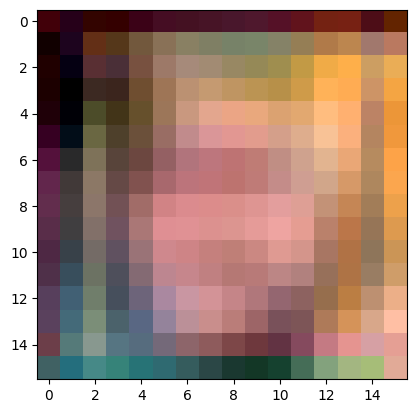

Resolution: 16*16  D_Loss: 0.1098  G_Loss: 6.0503  Alpha: 0.2869:   0%|          | 1479/599999 [28:09<248:58:26,  1.50s/it]

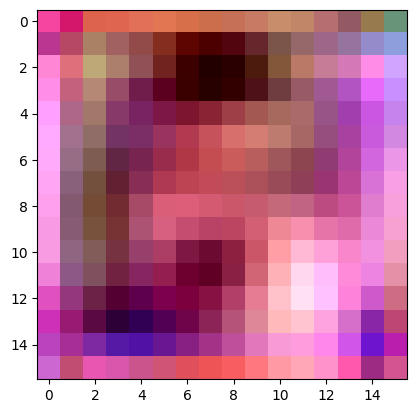

Resolution: 16*16  D_Loss: 1.9884  G_Loss: 8.3272  Alpha: 0.3083:   0%|          | 1519/599999 [29:11<249:58:38,  1.50s/it]

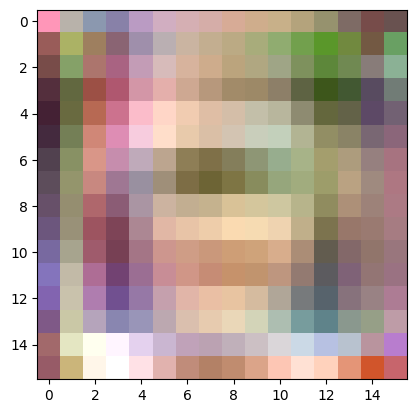

Resolution: 16*16  D_Loss: 0.0962  G_Loss: 4.4547  Alpha: 0.3296:   0%|          | 1559/599999 [30:11<248:52:01,  1.50s/it]

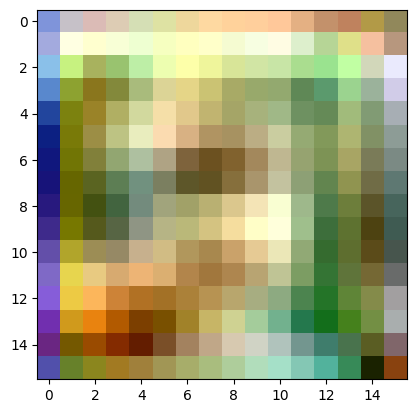

Resolution: 16*16  D_Loss: 0.1992  G_Loss: 4.5114  Alpha: 0.3509:   0%|          | 1599/599999 [31:12<249:34:00,  1.50s/it]

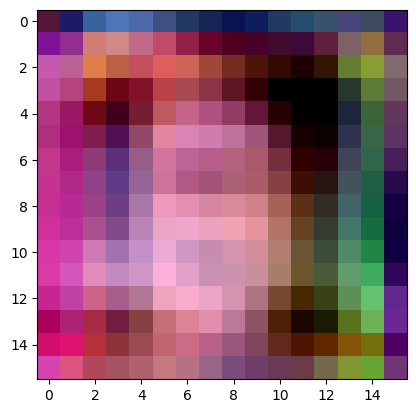

Resolution: 16*16  D_Loss: 0.0369  G_Loss: 6.4361  Alpha: 0.3723:   0%|          | 1639/599999 [32:12<250:29:43,  1.51s/it]

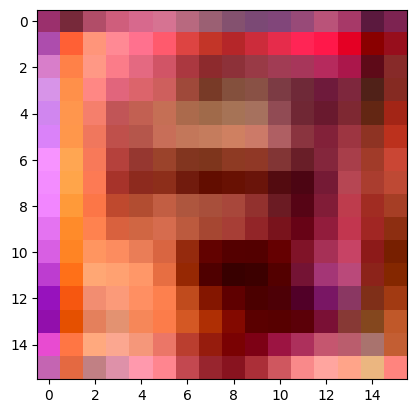

Resolution: 16*16  D_Loss: 0.1024  G_Loss: 4.7682  Alpha: 0.3936:   0%|          | 1679/599999 [33:12<248:32:52,  1.50s/it]

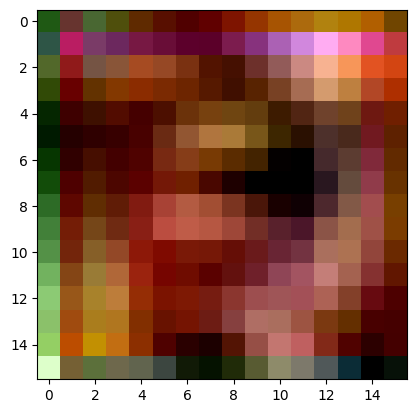

Resolution: 16*16  D_Loss: 0.0685  G_Loss: 4.8489  Alpha: 0.4149:   0%|          | 1719/599999 [34:12<249:23:25,  1.50s/it]

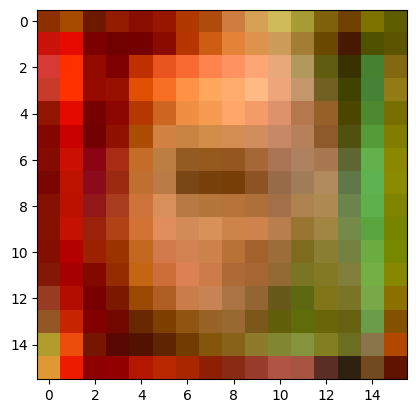

Resolution: 16*16  D_Loss: 0.1233  G_Loss: 5.0041  Alpha: 0.4363:   0%|          | 1759/599999 [35:13<249:27:35,  1.50s/it]

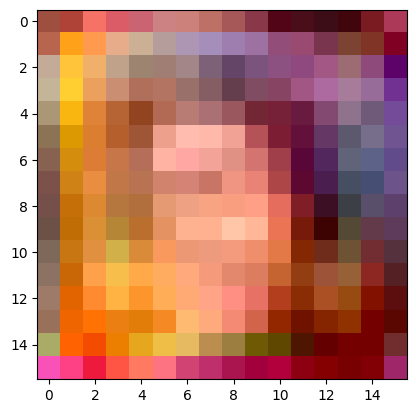

Resolution: 16*16  D_Loss: 0.2144  G_Loss: 6.1271  Alpha: 0.4576:   0%|          | 1799/599999 [36:13<250:44:27,  1.51s/it]

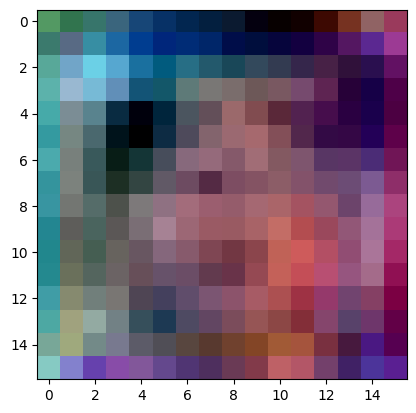

Resolution: 16*16  D_Loss: 0.1895  G_Loss: 4.3643  Alpha: 0.4789:   0%|          | 1839/599999 [37:13<249:37:24,  1.50s/it]

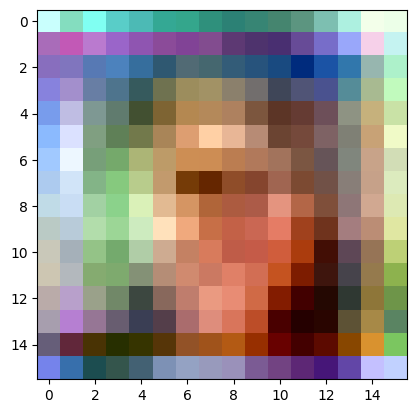

Resolution: 16*16  D_Loss: 0.1202  G_Loss: 4.3861  Alpha: 0.5003:   0%|          | 1879/599999 [38:13<248:57:07,  1.50s/it]

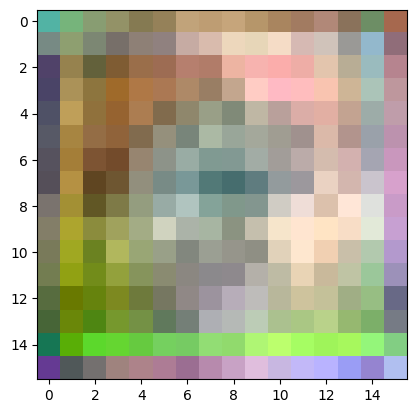

Resolution: 16*16  D_Loss: 0.1147  G_Loss: 5.0705  Alpha: 0.5216:   0%|          | 1919/599999 [39:14<249:39:42,  1.50s/it]

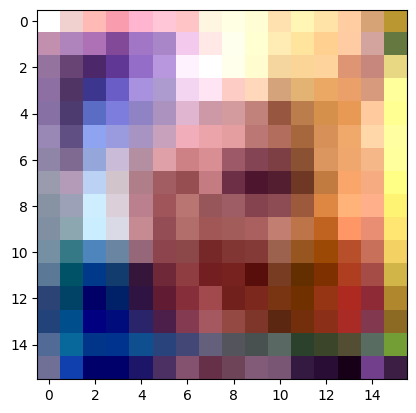

Resolution: 16*16  D_Loss: 0.0546  G_Loss: 7.9339  Alpha: 0.5429:   0%|          | 1959/599999 [40:14<249:23:33,  1.50s/it]

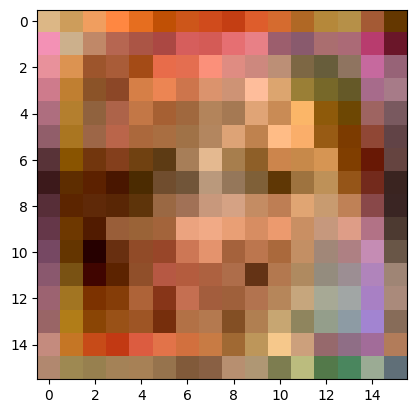

Resolution: 16*16  D_Loss: 0.1457  G_Loss: 5.2032  Alpha: 0.5643:   0%|          | 1999/599999 [41:16<328:47:12,  1.98s/it]

Iteration 1999 successfully saved.


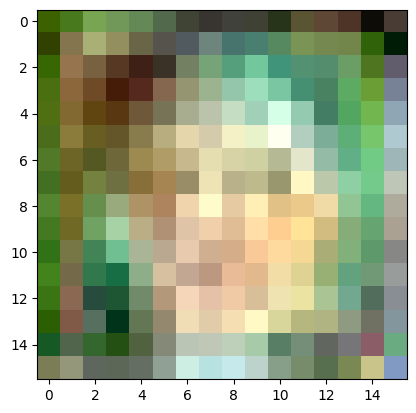

Resolution: 16*16  D_Loss: 0.1951  G_Loss: 4.5655  Alpha: 0.5856:   0%|          | 2039/599999 [42:16<256:53:06,  1.55s/it]

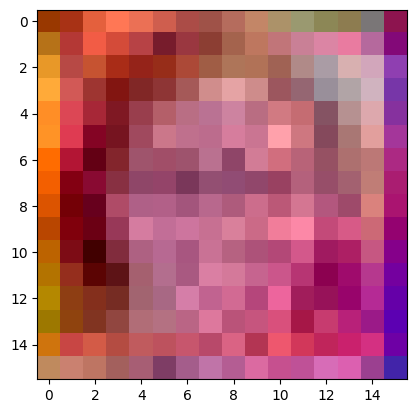

Resolution: 16*16  D_Loss: 0.1028  G_Loss: 4.7498  Alpha: 0.6069:   0%|          | 2079/599999 [43:16<249:37:35,  1.50s/it]

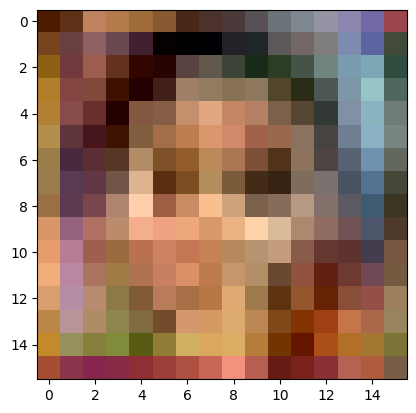

Resolution: 16*16  D_Loss: 0.1584  G_Loss: 4.2381  Alpha: 0.6283:   0%|          | 2119/599999 [44:17<250:14:55,  1.51s/it]

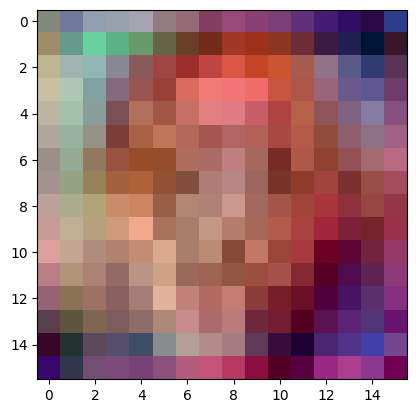

Resolution: 16*16  D_Loss: 0.1289  G_Loss: 3.8770  Alpha: 0.6496:   0%|          | 2159/599999 [45:17<249:15:17,  1.50s/it]

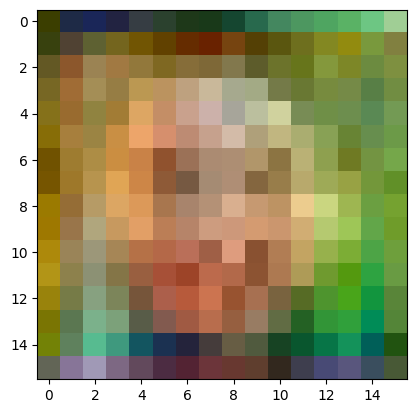

Resolution: 16*16  D_Loss: 0.1241  G_Loss: 5.6438  Alpha: 0.6709:   0%|          | 2199/599999 [46:17<249:31:28,  1.50s/it]

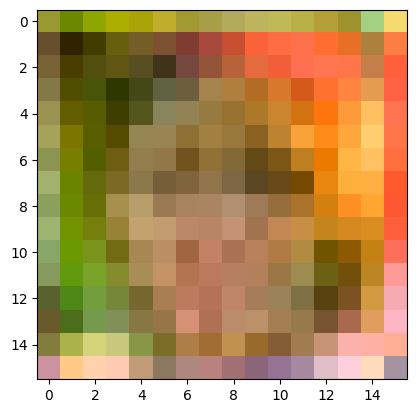

Resolution: 16*16  D_Loss: 0.0793  G_Loss: 4.9698  Alpha: 0.6923:   0%|          | 2239/599999 [47:17<249:04:30,  1.50s/it]

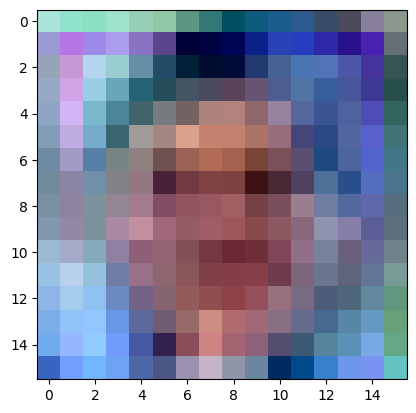

Resolution: 16*16  D_Loss: 0.0661  G_Loss: 5.0556  Alpha: 0.7136:   0%|          | 2279/599999 [48:18<249:50:37,  1.50s/it]

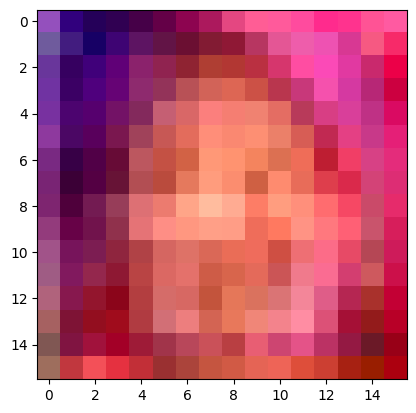

Resolution: 16*16  D_Loss: 0.7980  G_Loss: 11.8608  Alpha: 0.7349:   0%|          | 2319/599999 [49:18<249:38:49,  1.50s/it]

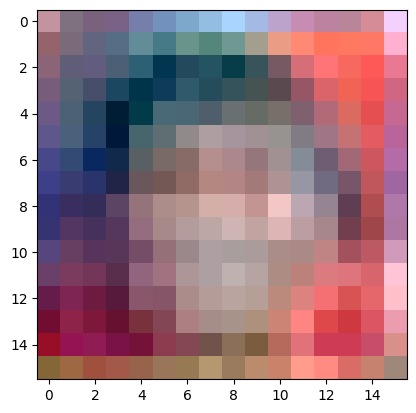

Resolution: 16*16  D_Loss: 0.1259  G_Loss: 5.3211  Alpha: 0.7563:   0%|          | 2359/599999 [50:19<249:14:26,  1.50s/it] 

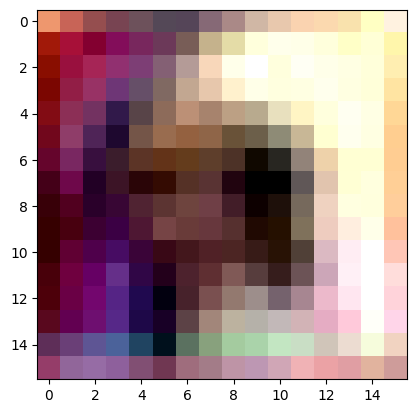

Resolution: 16*16  D_Loss: 4.5852  G_Loss: 49.9262  Alpha: 0.7776:   0%|          | 2399/599999 [51:19<249:58:38,  1.51s/it]

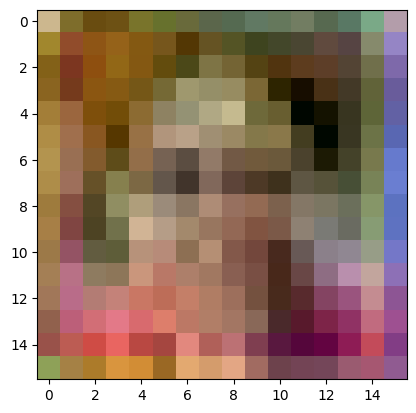

Resolution: 16*16  D_Loss: 0.2659  G_Loss: 3.9287  Alpha: 0.7989:   0%|          | 2439/599999 [52:19<249:52:23,  1.51s/it] 

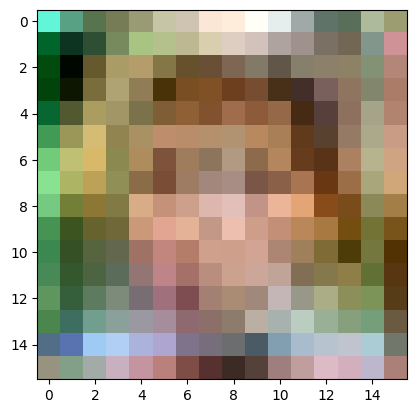

Resolution: 16*16  D_Loss: 0.2718  G_Loss: 3.7136  Alpha: 0.8203:   0%|          | 2479/599999 [53:20<249:20:25,  1.50s/it]

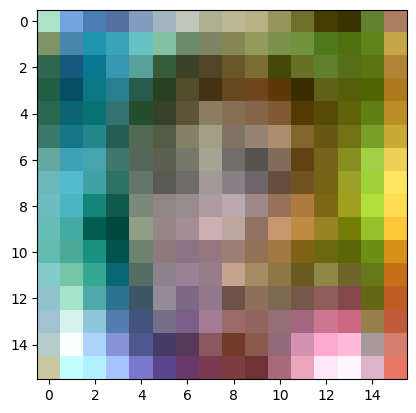

Resolution: 16*16  D_Loss: 0.0989  G_Loss: 3.8727  Alpha: 0.8416:   0%|          | 2519/599999 [54:20<248:44:15,  1.50s/it]

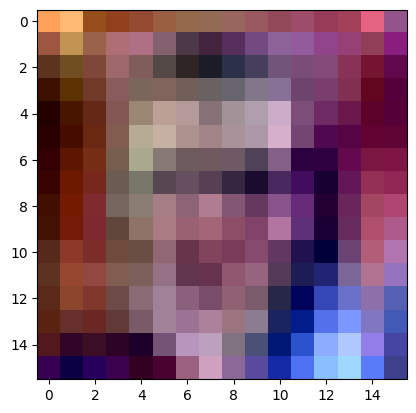

Resolution: 16*16  D_Loss: 0.1505  G_Loss: 7.2764  Alpha: 0.8629:   0%|          | 2559/599999 [55:20<248:59:28,  1.50s/it]

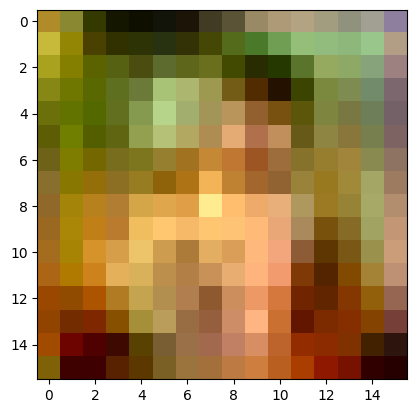

Resolution: 16*16  D_Loss: 0.1113  G_Loss: 5.1620  Alpha: 0.8843:   0%|          | 2599/599999 [56:21<249:20:01,  1.50s/it]

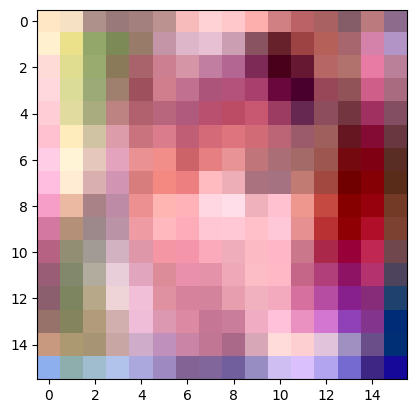

Resolution: 16*16  D_Loss: 0.0439  G_Loss: 5.8669  Alpha: 0.9056:   0%|          | 2639/599999 [57:21<248:34:30,  1.50s/it]

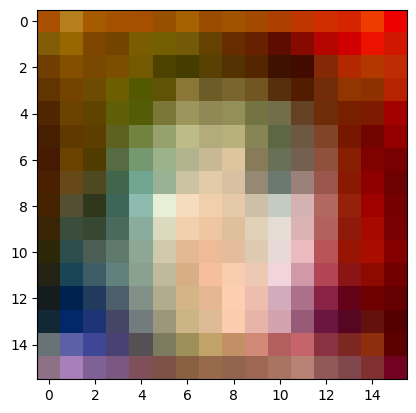

Resolution: 16*16  D_Loss: 0.1251  G_Loss: 8.9957  Alpha: 0.9269:   0%|          | 2679/599999 [58:21<249:36:22,  1.50s/it]

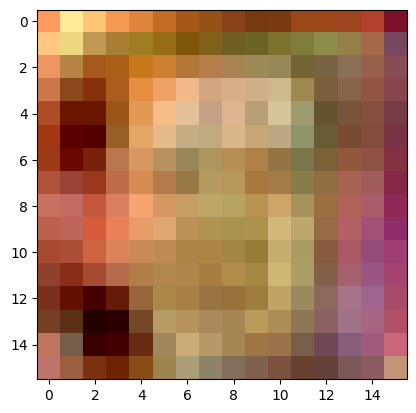

Resolution: 16*16  D_Loss: 0.1984  G_Loss: 4.6993  Alpha: 0.9483:   0%|          | 2719/599999 [59:22<249:16:31,  1.50s/it]

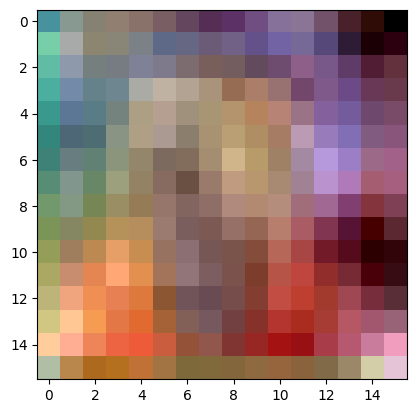

Resolution: 16*16  D_Loss: 0.0756  G_Loss: 6.0805  Alpha: 0.9696:   0%|          | 2759/599999 [1:00:22<248:28:32,  1.50s/it]

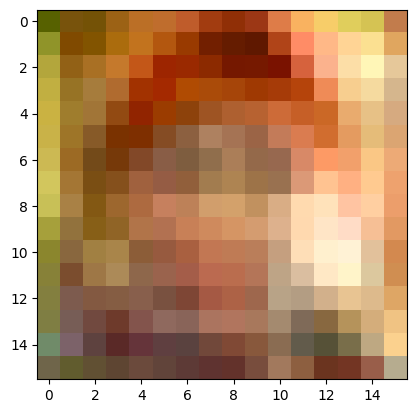

Resolution: 16*16  D_Loss: 0.0557  G_Loss: 6.0366  Alpha: 0.9909:   0%|          | 2799/599999 [1:01:22<249:10:02,  1.50s/it]

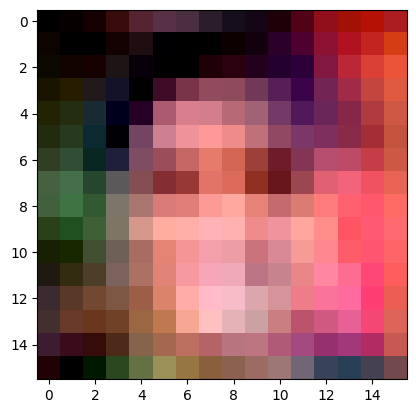

Resolution: 32*32  D_Loss: 0.0354  G_Loss: 7.7606  Alpha: 0.0059:   0%|          | 2839/599999 [1:02:40<375:16:31,  2.26s/it]

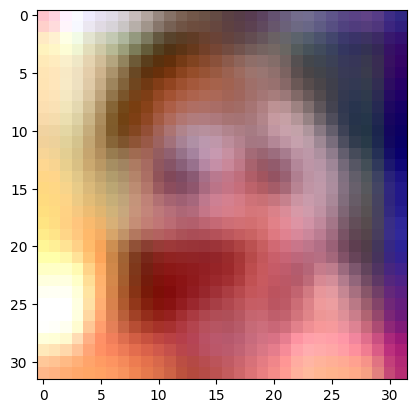

Resolution: 32*32  D_Loss: 0.1356  G_Loss: 6.4223  Alpha: 0.0165:   0%|          | 2879/599999 [1:04:10<375:00:48,  2.26s/it]

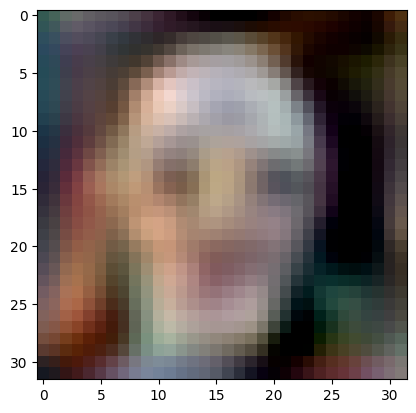

Resolution: 32*32  D_Loss: 0.3160  G_Loss: 3.8963  Alpha: 0.0272:   0%|          | 2919/599999 [1:05:41<375:12:42,  2.26s/it]

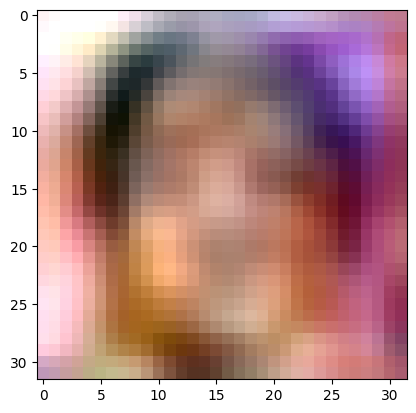

Resolution: 32*32  D_Loss: 0.1204  G_Loss: 4.1218  Alpha: 0.0379:   0%|          | 2959/599999 [1:07:12<375:41:52,  2.27s/it]

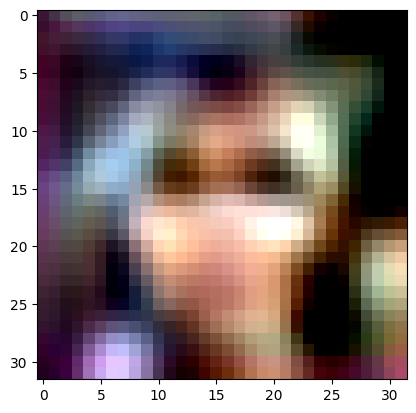

Resolution: 32*32  D_Loss: 0.0866  G_Loss: 4.9964  Alpha: 0.0485:   0%|          | 2999/599999 [1:08:45<500:31:12,  3.02s/it]

Iteration 2999 successfully saved.


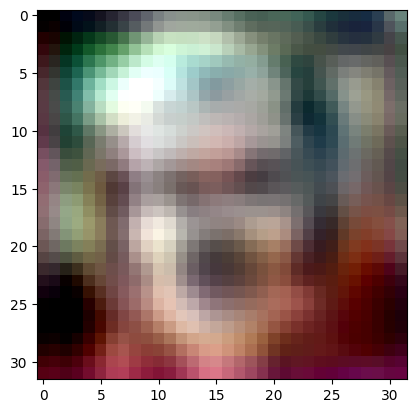

Resolution: 32*32  D_Loss: 0.1978  G_Loss: 5.1322  Alpha: 0.0592:   1%|          | 3039/599999 [1:10:15<374:31:02,  2.26s/it]

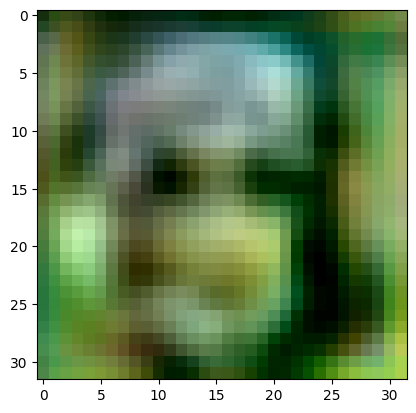

Resolution: 32*32  D_Loss: 0.1222  G_Loss: 7.3490  Alpha: 0.0699:   1%|          | 3079/599999 [1:11:46<375:47:24,  2.27s/it]

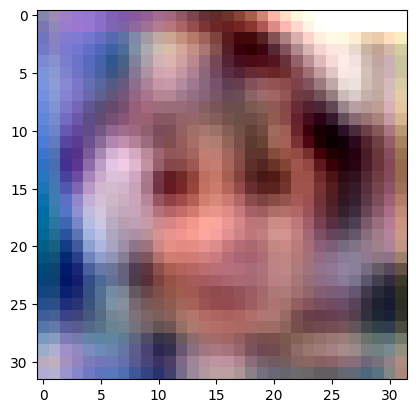

Resolution: 32*32  D_Loss: 0.1116  G_Loss: 4.4162  Alpha: 0.0805:   1%|          | 3119/599999 [1:13:16<376:24:24,  2.27s/it]

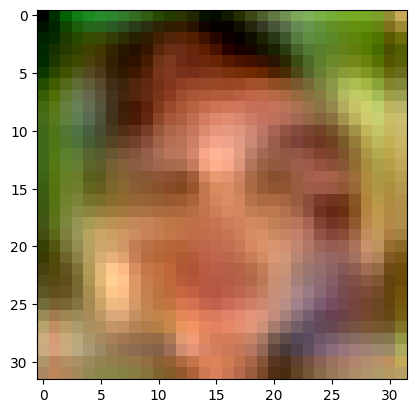

Resolution: 32*32  D_Loss: 0.0941  G_Loss: 4.5149  Alpha: 0.0912:   1%|          | 3159/599999 [1:14:47<375:44:59,  2.27s/it]

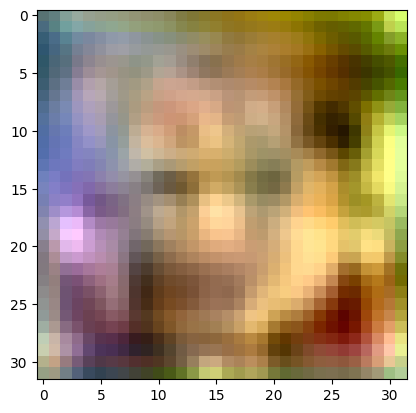

Resolution: 32*32  D_Loss: 0.2532  G_Loss: 3.5294  Alpha: 0.1019:   1%|          | 3199/599999 [1:16:18<375:38:07,  2.27s/it]

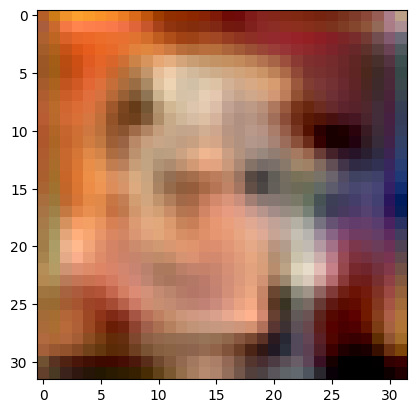

Resolution: 32*32  D_Loss: 0.0777  G_Loss: 5.1397  Alpha: 0.1125:   1%|          | 3239/599999 [1:17:49<375:14:28,  2.26s/it]

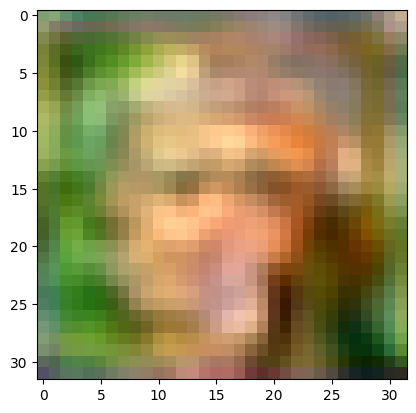

Resolution: 32*32  D_Loss: 0.0850  G_Loss: 5.5953  Alpha: 0.1232:   1%|          | 3279/599999 [1:19:19<375:20:42,  2.26s/it]

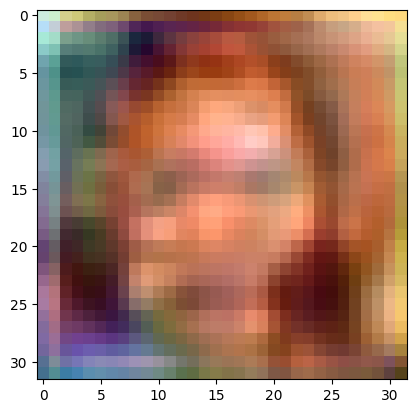

Resolution: 32*32  D_Loss: 0.4303  G_Loss: 4.1307  Alpha: 0.1339:   1%|          | 3319/599999 [1:20:50<375:02:54,  2.26s/it]

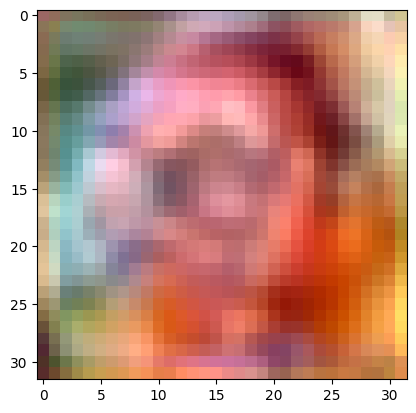

Resolution: 32*32  D_Loss: 0.0894  G_Loss: 5.7451  Alpha: 0.1445:   1%|          | 3359/599999 [1:22:21<375:21:40,  2.26s/it]

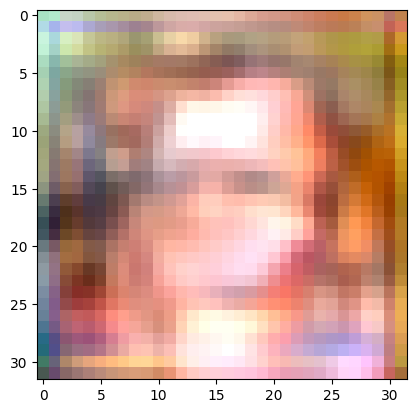

Resolution: 32*32  D_Loss: 0.1654  G_Loss: 4.2749  Alpha: 0.1552:   1%|          | 3399/599999 [1:23:52<374:52:17,  2.26s/it]

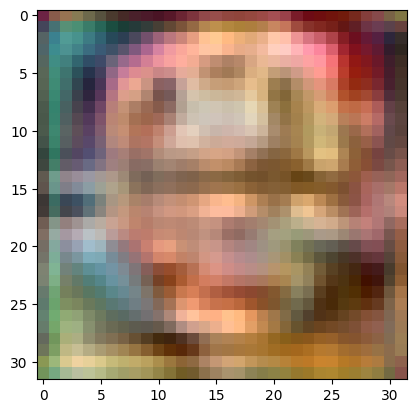

Resolution: 32*32  D_Loss: 0.3112  G_Loss: 4.6231  Alpha: 0.1659:   1%|          | 3439/599999 [1:25:23<374:53:43,  2.26s/it]

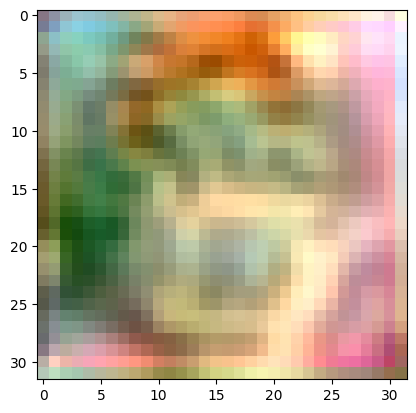

Resolution: 32*32  D_Loss: 1.0267  G_Loss: 4.5012  Alpha: 0.1765:   1%|          | 3479/599999 [1:26:54<375:22:36,  2.27s/it]

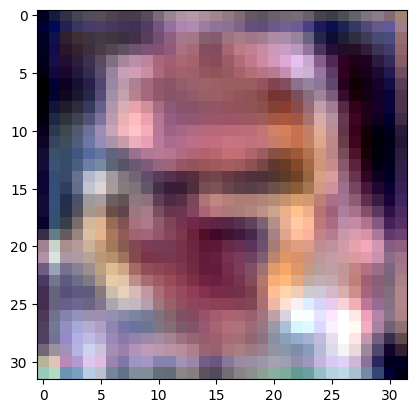

Resolution: 32*32  D_Loss: 0.0770  G_Loss: 3.7349  Alpha: 0.1872:   1%|          | 3519/599999 [1:28:24<375:30:24,  2.27s/it]

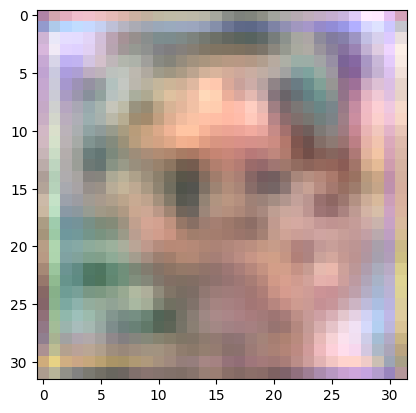

Resolution: 32*32  D_Loss: 0.1714  G_Loss: 3.9615  Alpha: 0.1979:   1%|          | 3559/599999 [1:29:55<375:24:57,  2.27s/it]

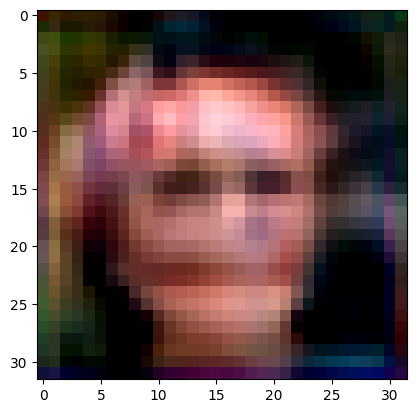

Resolution: 32*32  D_Loss: 0.3147  G_Loss: 8.0243  Alpha: 0.2085:   1%|          | 3599/599999 [1:31:26<374:48:04,  2.26s/it]

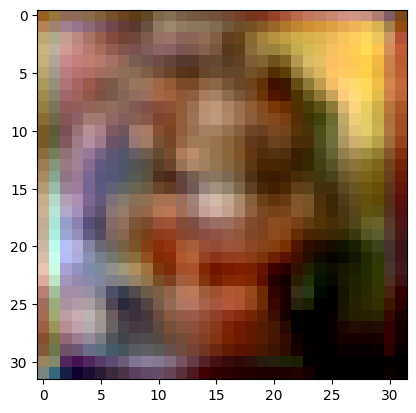

Resolution: 32*32  D_Loss: 0.0966  G_Loss: 4.3245  Alpha: 0.2192:   1%|          | 3639/599999 [1:32:57<374:39:29,  2.26s/it]

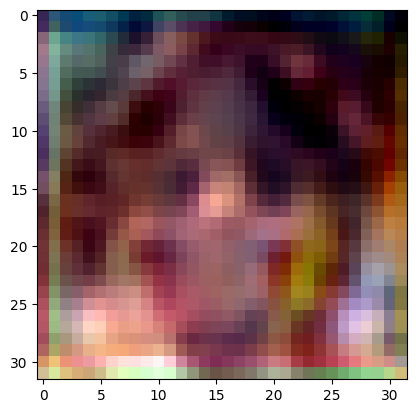

Resolution: 32*32  D_Loss: 0.2349  G_Loss: 3.2992  Alpha: 0.2299:   1%|          | 3679/599999 [1:34:27<376:07:33,  2.27s/it]

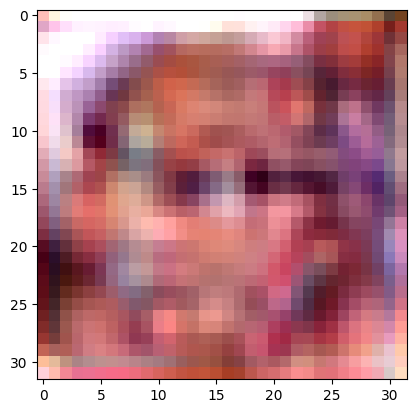

Resolution: 32*32  D_Loss: 0.1710  G_Loss: 4.1128  Alpha: 0.2405:   1%|          | 3719/599999 [1:35:58<373:29:05,  2.25s/it]

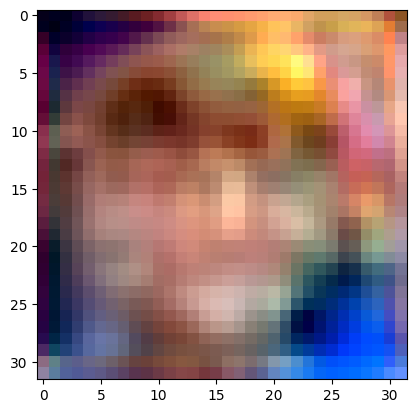

Resolution: 32*32  D_Loss: 0.2214  G_Loss: 5.7706  Alpha: 0.2512:   1%|          | 3759/599999 [1:37:29<374:26:44,  2.26s/it]

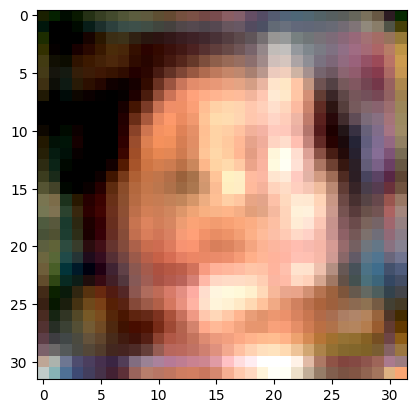

Resolution: 32*32  D_Loss: 0.4732  G_Loss: 4.3428  Alpha: 0.2619:   1%|          | 3799/599999 [1:38:59<375:08:58,  2.27s/it]

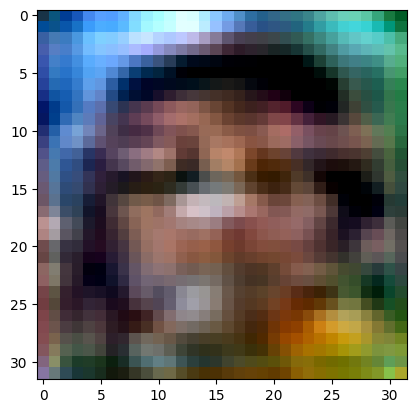

Resolution: 32*32  D_Loss: 0.1679  G_Loss: 3.9753  Alpha: 0.2725:   1%|          | 3839/599999 [1:40:30<375:52:29,  2.27s/it]

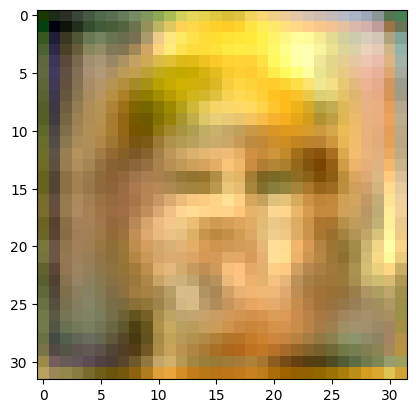

Resolution: 32*32  D_Loss: 0.3048  G_Loss: 5.5122  Alpha: 0.2832:   1%|          | 3879/599999 [1:42:01<373:56:33,  2.26s/it]

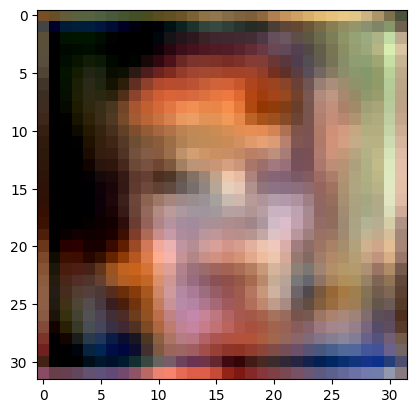

Resolution: 32*32  D_Loss: 0.1480  G_Loss: 4.1114  Alpha: 0.2939:   1%|          | 3919/599999 [1:43:32<375:19:16,  2.27s/it]

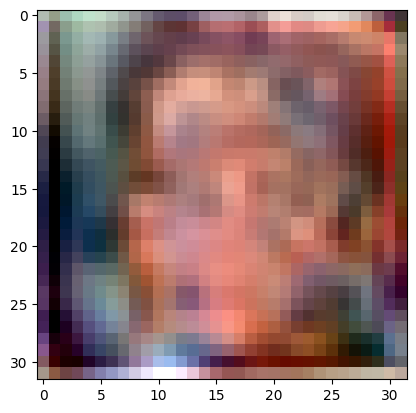

Resolution: 32*32  D_Loss: 0.2464  G_Loss: 3.0902  Alpha: 0.3045:   1%|          | 3959/599999 [1:45:02<374:50:03,  2.26s/it]

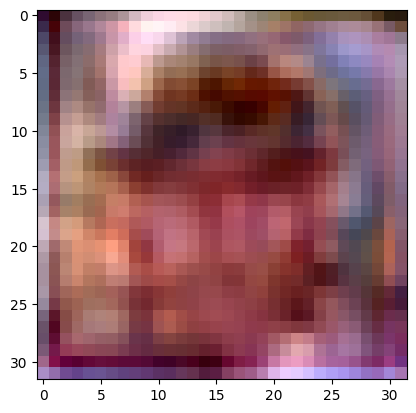

Resolution: 32*32  D_Loss: 0.0992  G_Loss: 4.6802  Alpha: 0.3152:   1%|          | 3999/599999 [1:46:36<494:57:40,  2.99s/it]

Iteration 3999 successfully saved.


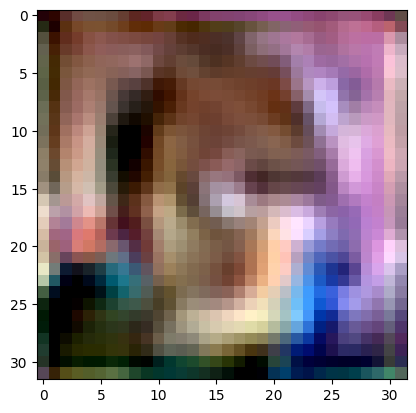

Resolution: 32*32  D_Loss: 0.2076  G_Loss: 5.3434  Alpha: 0.3259:   1%|          | 4039/599999 [1:48:05<374:42:21,  2.26s/it]

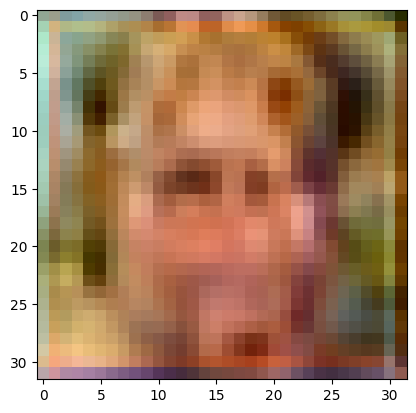

Resolution: 32*32  D_Loss: 0.1297  G_Loss: 4.3075  Alpha: 0.3365:   1%|          | 4079/599999 [1:49:36<374:48:07,  2.26s/it]

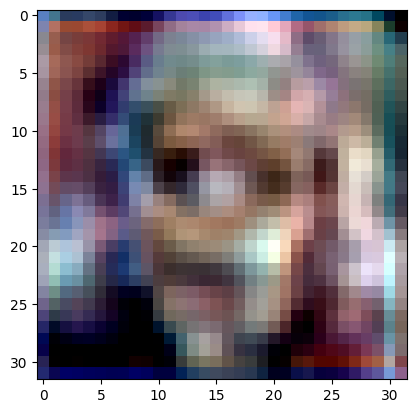

Resolution: 32*32  D_Loss: 0.1482  G_Loss: 3.6477  Alpha: 0.3472:   1%|          | 4119/599999 [1:51:07<373:47:30,  2.26s/it]

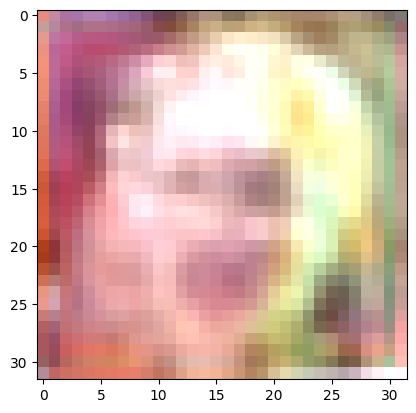

Resolution: 32*32  D_Loss: 0.3271  G_Loss: 4.8574  Alpha: 0.3579:   1%|          | 4159/599999 [1:52:38<374:05:50,  2.26s/it]

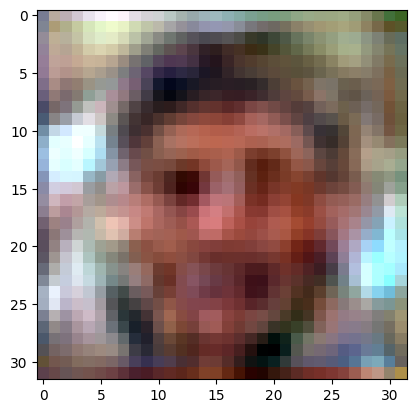

Resolution: 32*32  D_Loss: 0.1936  G_Loss: 3.0089  Alpha: 0.3685:   1%|          | 4199/599999 [1:54:08<374:13:20,  2.26s/it]

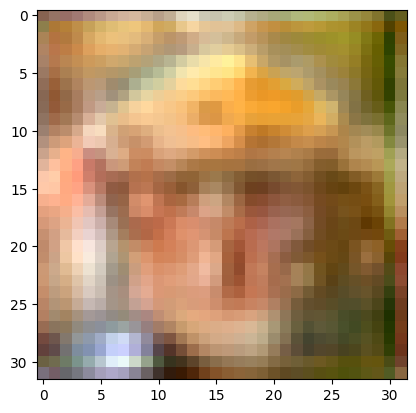

Resolution: 32*32  D_Loss: 0.1084  G_Loss: 4.5238  Alpha: 0.3792:   1%|          | 4239/599999 [1:55:39<374:49:50,  2.26s/it]

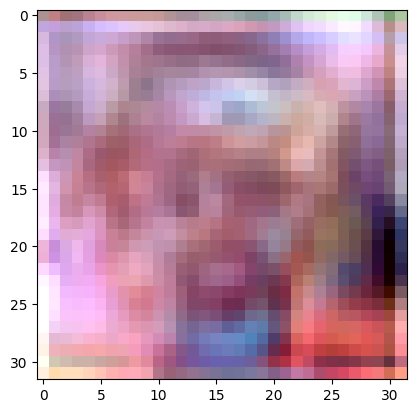

Resolution: 32*32  D_Loss: 0.1737  G_Loss: 5.8117  Alpha: 0.3899:   1%|          | 4279/599999 [1:57:10<374:11:29,  2.26s/it]

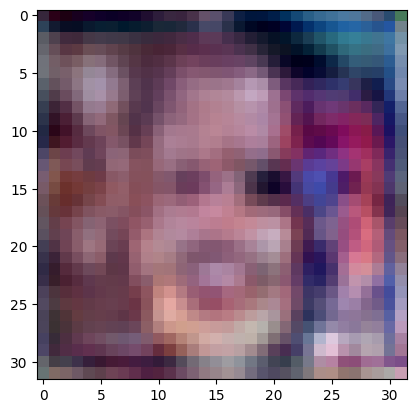

Resolution: 32*32  D_Loss: 0.1449  G_Loss: 7.2925  Alpha: 0.4005:   1%|          | 4319/599999 [1:58:40<373:42:55,  2.26s/it]

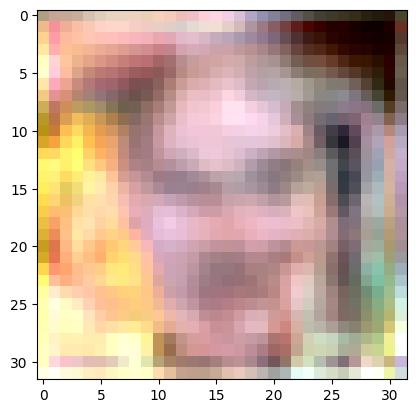

Resolution: 32*32  D_Loss: 0.1171  G_Loss: 3.9693  Alpha: 0.4112:   1%|          | 4359/599999 [2:00:11<374:35:14,  2.26s/it]

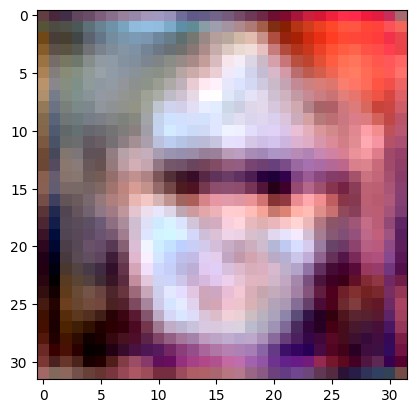

Resolution: 32*32  D_Loss: 0.3906  G_Loss: 3.8734  Alpha: 0.4219:   1%|          | 4399/599999 [2:01:42<375:44:16,  2.27s/it]

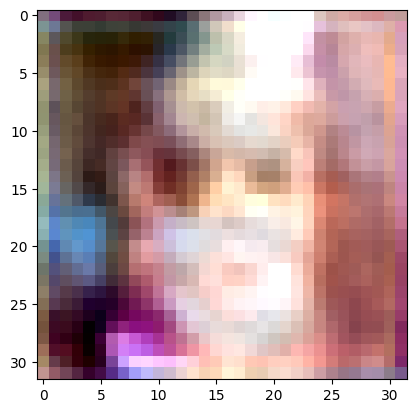

Resolution: 32*32  D_Loss: 0.2757  G_Loss: 4.0539  Alpha: 0.4325:   1%|          | 4439/599999 [2:03:13<376:03:40,  2.27s/it]

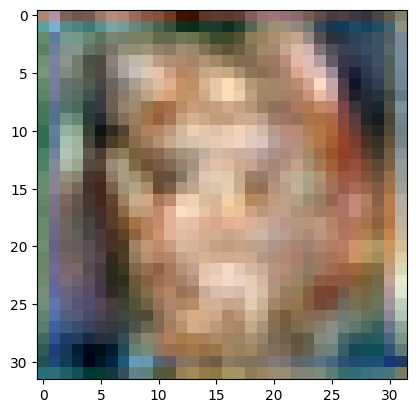

Resolution: 32*32  D_Loss: 0.4582  G_Loss: 2.2631  Alpha: 0.4432:   1%|          | 4479/599999 [2:04:43<374:41:11,  2.27s/it]

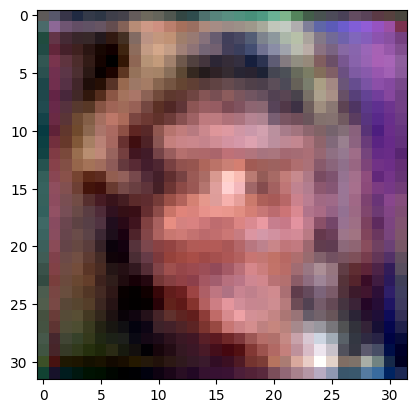

Resolution: 32*32  D_Loss: 0.1265  G_Loss: 3.6105  Alpha: 0.4539:   1%|          | 4519/599999 [2:06:14<374:38:40,  2.26s/it]

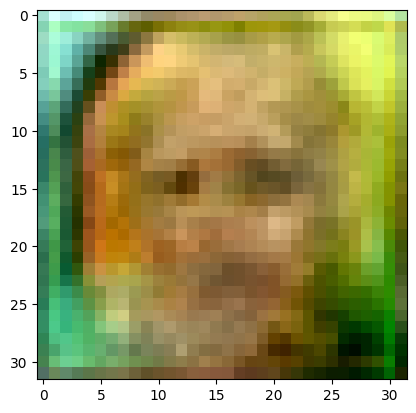

Resolution: 32*32  D_Loss: 0.1165  G_Loss: 4.5616  Alpha: 0.4645:   1%|          | 4559/599999 [2:07:45<374:13:34,  2.26s/it]

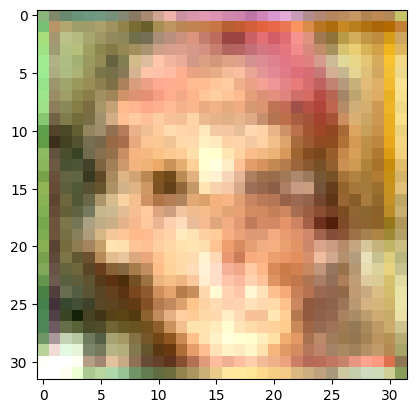

Resolution: 32*32  D_Loss: 0.1293  G_Loss: 4.0576  Alpha: 0.4752:   1%|          | 4599/599999 [2:09:16<374:37:22,  2.27s/it]

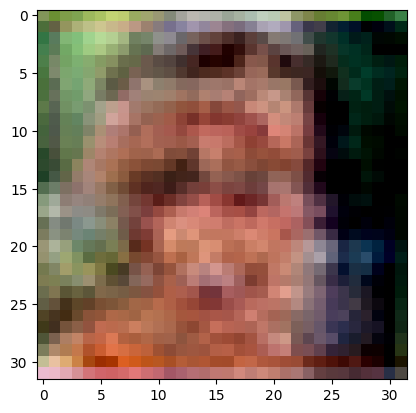

Resolution: 32*32  D_Loss: 0.4614  G_Loss: 4.7533  Alpha: 0.4859:   1%|          | 4639/599999 [2:10:47<374:18:51,  2.26s/it]

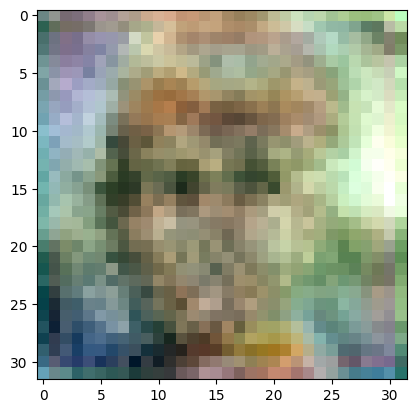

Resolution: 32*32  D_Loss: 0.7219  G_Loss: 2.9218  Alpha: 0.4965:   1%|          | 4679/599999 [2:12:18<374:29:38,  2.26s/it]

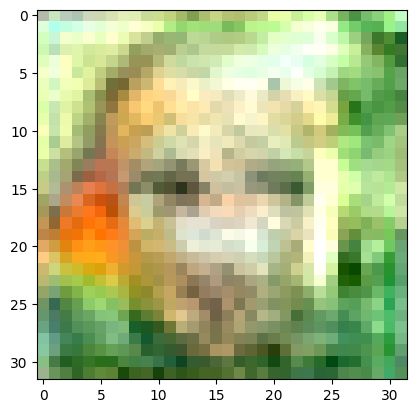

Resolution: 32*32  D_Loss: 0.0912  G_Loss: 5.6115  Alpha: 0.5072:   1%|          | 4719/599999 [2:13:48<373:49:57,  2.26s/it]

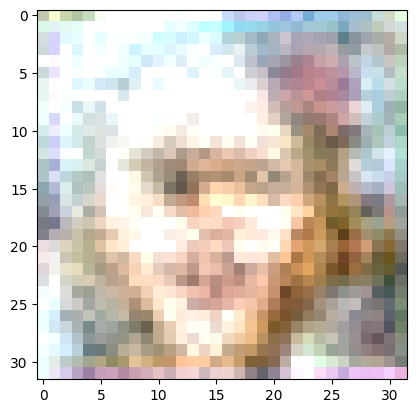

Resolution: 32*32  D_Loss: 0.1645  G_Loss: 5.8049  Alpha: 0.5179:   1%|          | 4759/599999 [2:15:19<375:29:49,  2.27s/it]

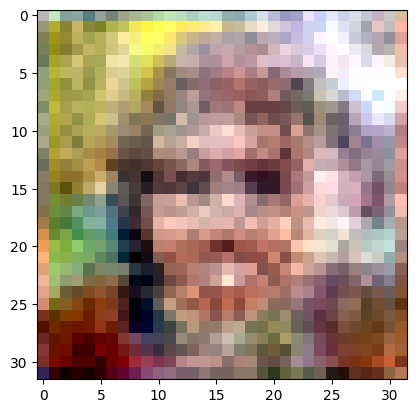

Resolution: 32*32  D_Loss: 0.4284  G_Loss: 3.3099  Alpha: 0.5285:   1%|          | 4799/599999 [2:16:50<373:58:08,  2.26s/it]

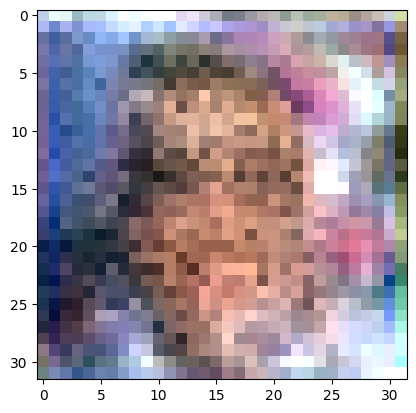

Resolution: 32*32  D_Loss: 0.2922  G_Loss: 4.8737  Alpha: 0.5392:   1%|          | 4839/599999 [2:18:21<374:37:06,  2.27s/it]

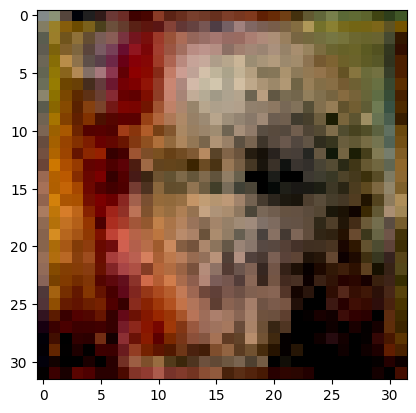

Resolution: 32*32  D_Loss: 0.2527  G_Loss: 4.0621  Alpha: 0.5499:   1%|          | 4879/599999 [2:19:52<374:16:25,  2.26s/it]

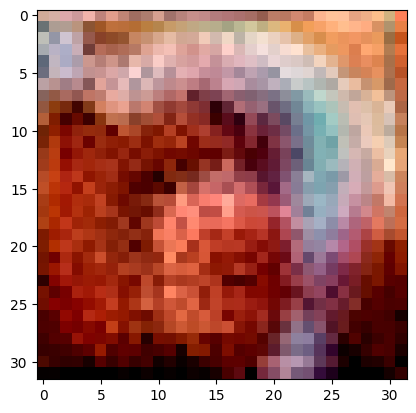

Resolution: 32*32  D_Loss: 0.1389  G_Loss: 5.0447  Alpha: 0.5605:   1%|          | 4919/599999 [2:21:23<375:17:47,  2.27s/it]

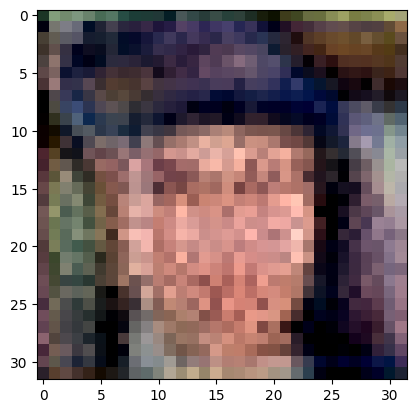

Resolution: 32*32  D_Loss: 0.3733  G_Loss: 3.7367  Alpha: 0.5712:   1%|          | 4959/599999 [2:22:53<374:22:32,  2.26s/it]

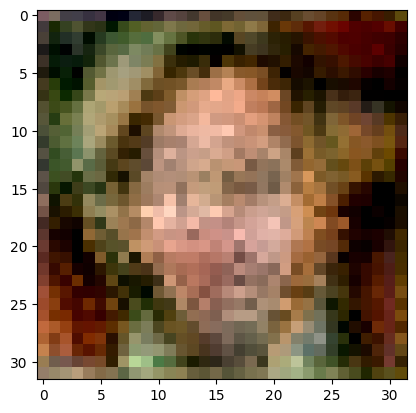

Resolution: 32*32  D_Loss: 0.3618  G_Loss: 3.0625  Alpha: 0.5819:   1%|          | 4999/599999 [2:24:26<493:59:58,  2.99s/it]

Iteration 4999 successfully saved.


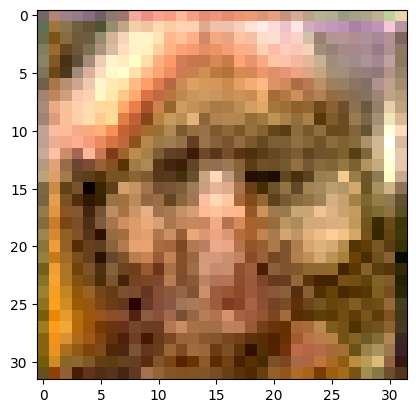

Resolution: 32*32  D_Loss: 0.3355  G_Loss: 3.8133  Alpha: 0.5925:   1%|          | 5039/599999 [2:25:57<374:05:54,  2.26s/it]

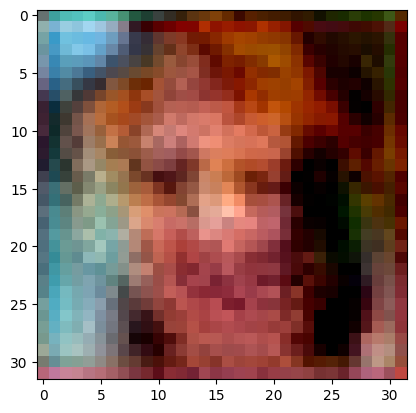

Resolution: 32*32  D_Loss: 0.2907  G_Loss: 5.2095  Alpha: 0.6032:   1%|          | 5079/599999 [2:27:28<374:54:08,  2.27s/it]

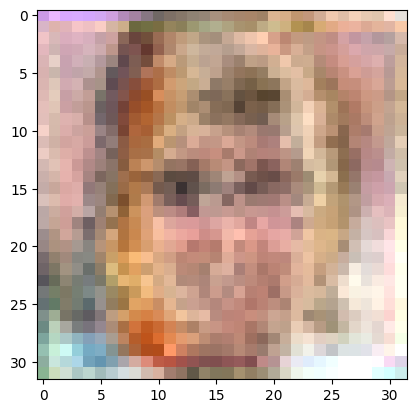

Resolution: 32*32  D_Loss: 0.2349  G_Loss: 4.7161  Alpha: 0.6139:   1%|          | 5119/599999 [2:28:59<373:50:00,  2.26s/it]

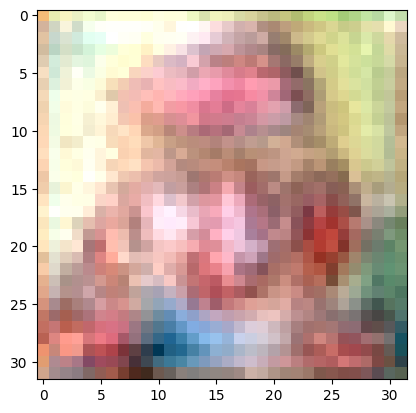

Resolution: 32*32  D_Loss: 0.1881  G_Loss: 4.1853  Alpha: 0.6245:   1%|          | 5159/599999 [2:30:30<375:22:55,  2.27s/it]

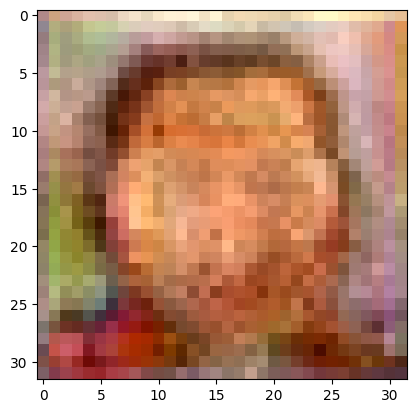

Resolution: 32*32  D_Loss: 0.1500  G_Loss: 5.4312  Alpha: 0.6352:   1%|          | 5199/599999 [2:32:00<373:51:18,  2.26s/it]

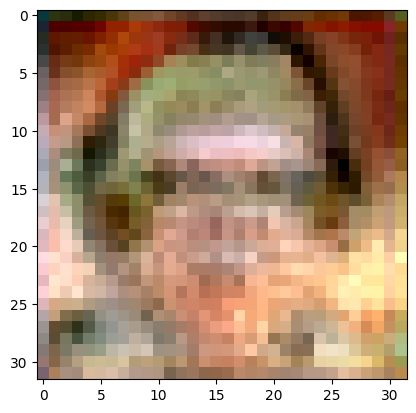

Resolution: 32*32  D_Loss: 0.2684  G_Loss: 4.0132  Alpha: 0.6459:   1%|          | 5239/599999 [2:33:31<373:31:03,  2.26s/it]

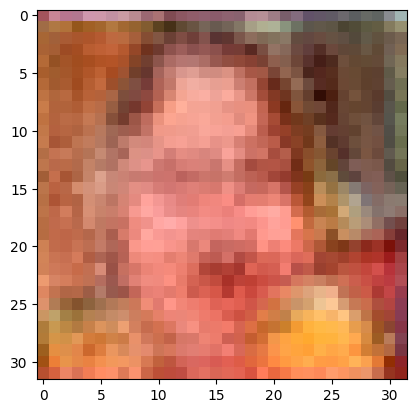

Resolution: 32*32  D_Loss: 0.1308  G_Loss: 4.6967  Alpha: 0.6565:   1%|          | 5279/599999 [2:35:02<375:19:27,  2.27s/it]

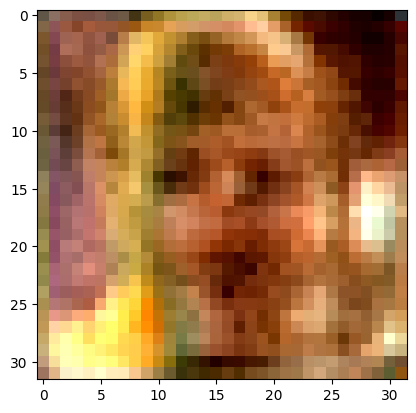

Resolution: 32*32  D_Loss: 0.5339  G_Loss: 5.2019  Alpha: 0.6672:   1%|          | 5319/599999 [2:36:33<375:05:10,  2.27s/it]

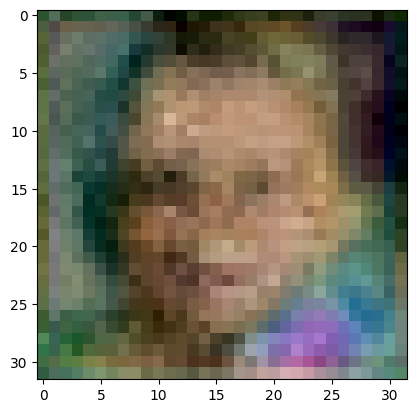

Resolution: 32*32  D_Loss: 0.1889  G_Loss: 4.2144  Alpha: 0.6779:   1%|          | 5359/599999 [2:38:04<374:39:16,  2.27s/it]

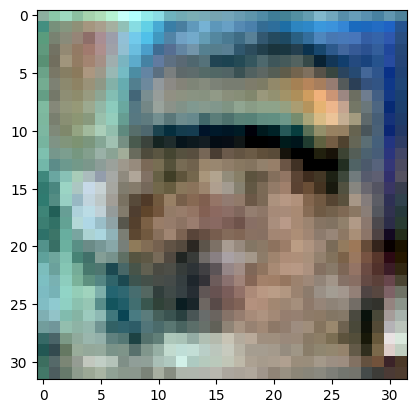

Resolution: 32*32  D_Loss: 0.0667  G_Loss: 4.0705  Alpha: 0.6885:   1%|          | 5399/599999 [2:39:35<373:52:51,  2.26s/it]

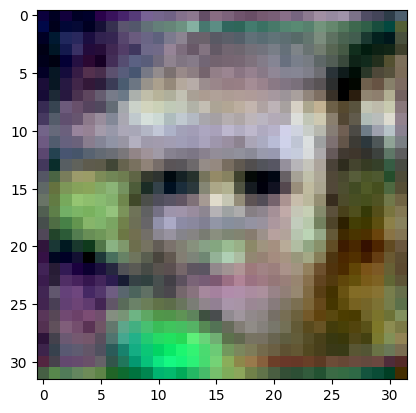

Resolution: 32*32  D_Loss: 0.1015  G_Loss: 4.9349  Alpha: 0.6992:   1%|          | 5439/599999 [2:41:06<373:20:46,  2.26s/it]

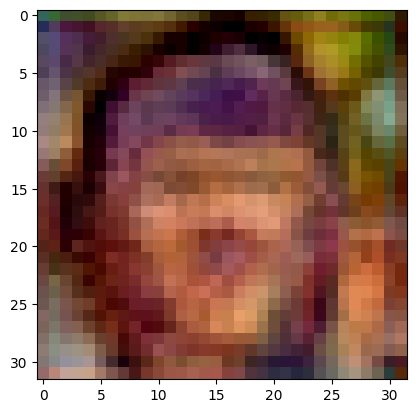

Resolution: 32*32  D_Loss: 0.1134  G_Loss: 3.9506  Alpha: 0.7099:   1%|          | 5479/599999 [2:42:37<374:52:49,  2.27s/it]

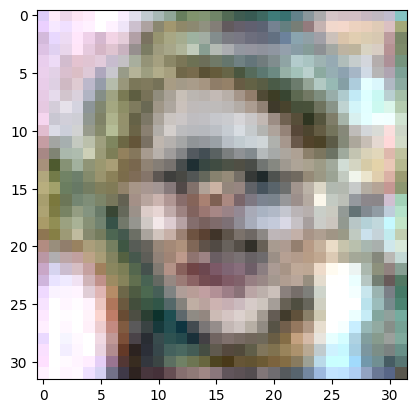

Resolution: 32*32  D_Loss: 0.1899  G_Loss: 3.8161  Alpha: 0.7205:   1%|          | 5519/599999 [2:44:08<374:04:48,  2.27s/it]

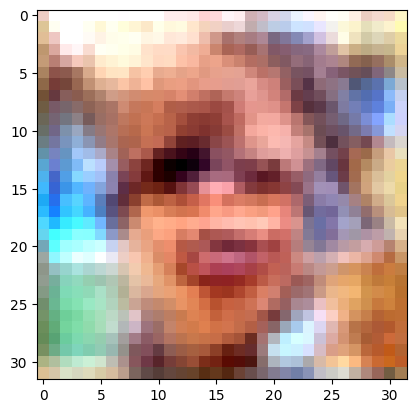

Resolution: 32*32  D_Loss: 0.1239  G_Loss: 4.2614  Alpha: 0.7312:   1%|          | 5559/599999 [2:45:39<374:35:31,  2.27s/it]

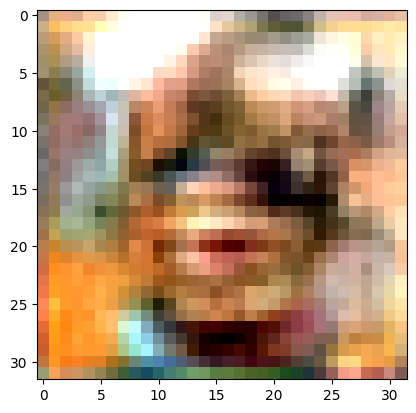

Resolution: 32*32  D_Loss: 0.2870  G_Loss: 5.0496  Alpha: 0.7419:   1%|          | 5599/599999 [2:47:10<374:15:36,  2.27s/it]

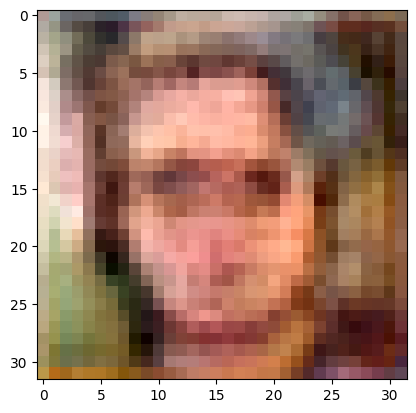

Resolution: 32*32  D_Loss: 0.5019  G_Loss: 3.6528  Alpha: 0.7525:   1%|          | 5639/599999 [2:48:41<374:53:27,  2.27s/it]

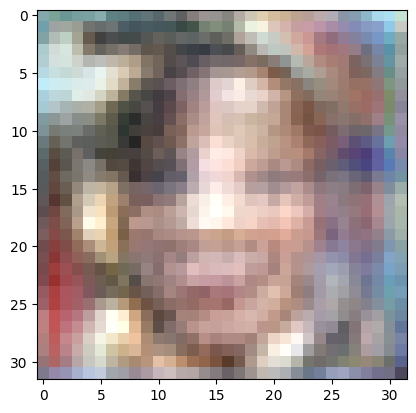

Resolution: 32*32  D_Loss: 0.2970  G_Loss: 3.7711  Alpha: 0.7632:   1%|          | 5679/599999 [2:50:12<374:54:02,  2.27s/it]

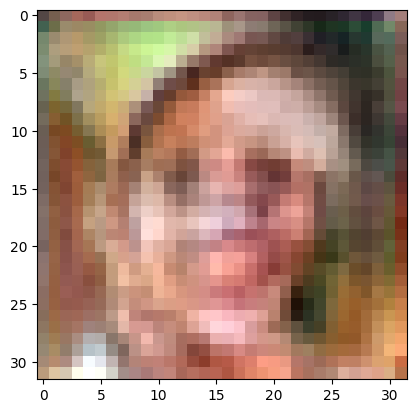

Resolution: 32*32  D_Loss: 0.1616  G_Loss: 3.5821  Alpha: 0.7739:   1%|          | 5719/599999 [2:51:43<373:15:12,  2.26s/it]

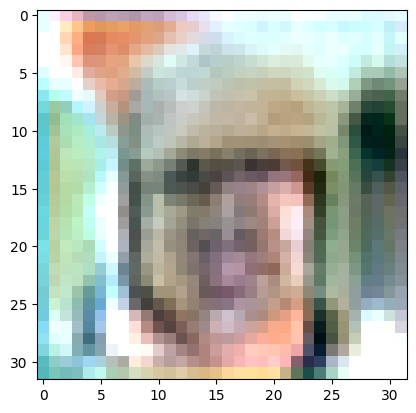

Resolution: 32*32  D_Loss: 0.2881  G_Loss: 6.3246  Alpha: 0.7845:   1%|          | 5759/599999 [2:53:14<373:44:11,  2.26s/it]

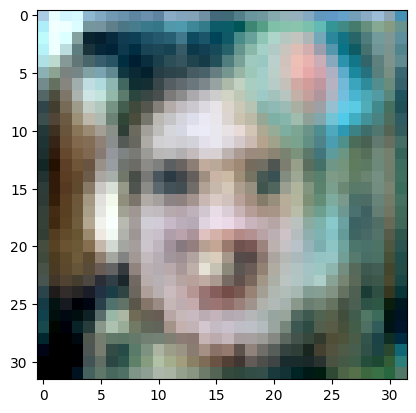

Resolution: 32*32  D_Loss: 0.7028  G_Loss: 4.9973  Alpha: 0.7952:   1%|          | 5799/599999 [2:54:45<373:35:09,  2.26s/it]

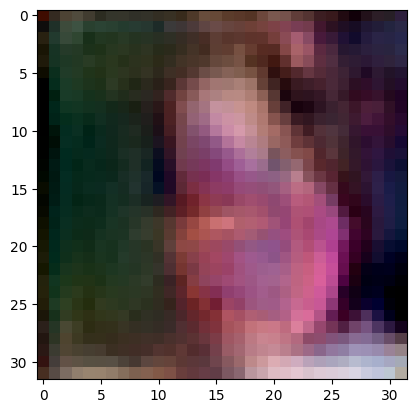

Resolution: 32*32  D_Loss: 0.1984  G_Loss: 5.1973  Alpha: 0.8059:   1%|          | 5839/599999 [2:56:15<374:39:07,  2.27s/it]

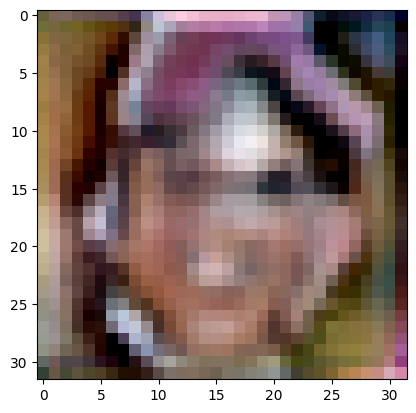

Resolution: 32*32  D_Loss: 1.1520  G_Loss: 1.8922  Alpha: 0.8165:   1%|          | 5879/599999 [2:57:46<374:15:47,  2.27s/it]

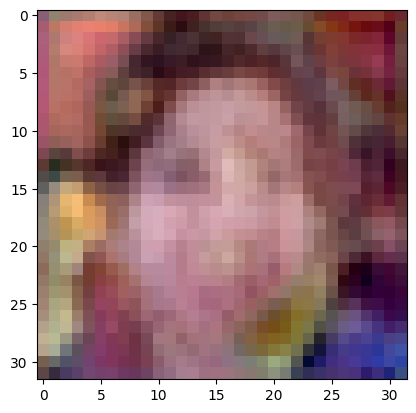

Resolution: 32*32  D_Loss: 0.3046  G_Loss: 6.3685  Alpha: 0.8272:   1%|          | 5919/599999 [2:59:17<372:46:26,  2.26s/it]

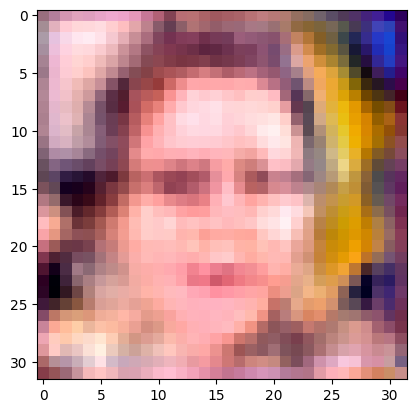

Resolution: 32*32  D_Loss: 0.2147  G_Loss: 5.5495  Alpha: 0.8379:   1%|          | 5959/599999 [3:00:48<374:20:19,  2.27s/it]

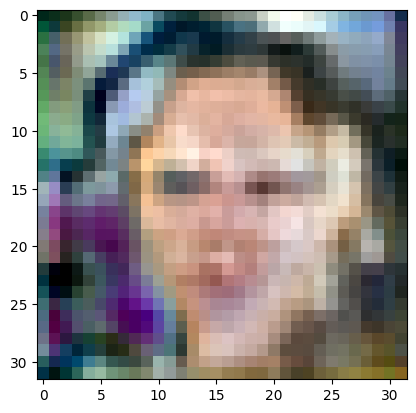

Resolution: 32*32  D_Loss: 0.2867  G_Loss: 3.9734  Alpha: 0.8485:   1%|          | 5999/599999 [3:02:21<471:48:24,  2.86s/it]

Iteration 5999 successfully saved.


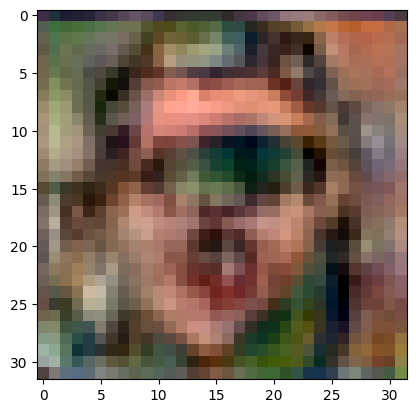

Resolution: 32*32  D_Loss: 0.1766  G_Loss: 3.3675  Alpha: 0.8592:   1%|          | 6039/599999 [3:03:51<374:54:07,  2.27s/it]

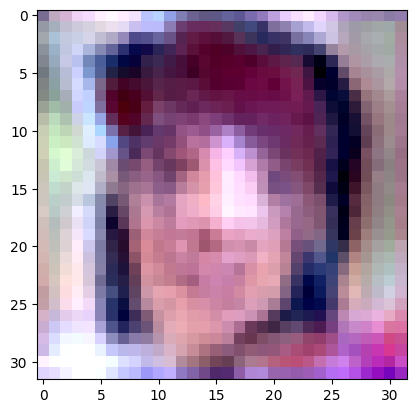

Resolution: 32*32  D_Loss: 0.1392  G_Loss: 4.2768  Alpha: 0.8699:   1%|          | 6079/599999 [3:05:22<374:47:36,  2.27s/it]

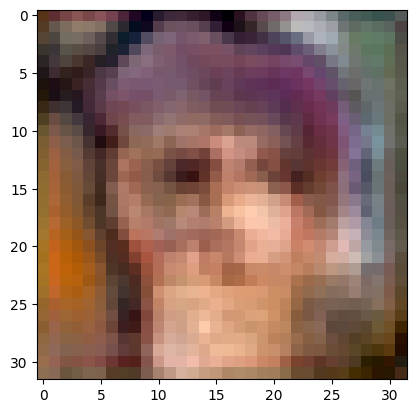

Resolution: 32*32  D_Loss: 0.1351  G_Loss: 4.4710  Alpha: 0.8805:   1%|          | 6119/599999 [3:06:53<374:09:06,  2.27s/it]

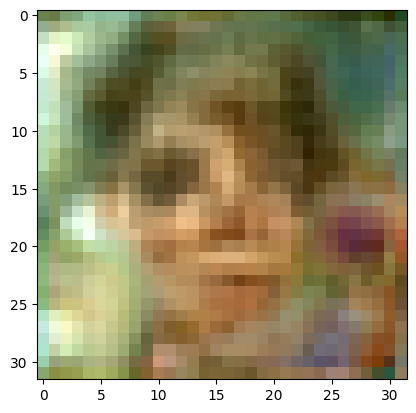

Resolution: 32*32  D_Loss: 0.7787  G_Loss: 7.3723  Alpha: 0.8912:   1%|          | 6159/599999 [3:08:24<375:06:57,  2.27s/it]

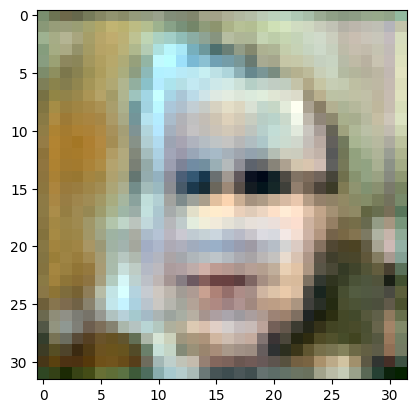

Resolution: 32*32  D_Loss: 0.1145  G_Loss: 4.0202  Alpha: 0.9019:   1%|          | 6199/599999 [3:09:55<374:42:23,  2.27s/it]

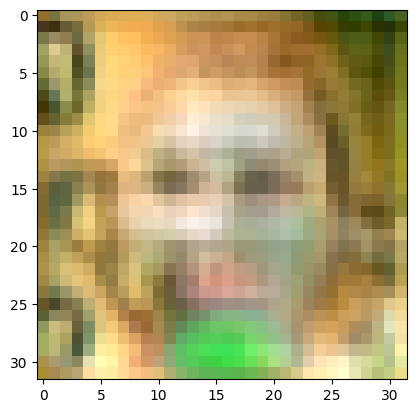

Resolution: 32*32  D_Loss: 0.1093  G_Loss: 3.9014  Alpha: 0.9125:   1%|          | 6239/599999 [3:11:26<374:31:03,  2.27s/it]

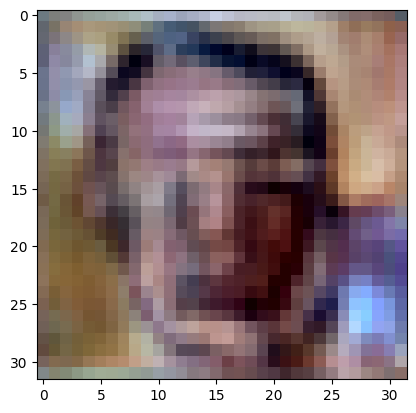

Resolution: 32*32  D_Loss: 0.0762  G_Loss: 4.6985  Alpha: 0.9232:   1%|          | 6279/599999 [3:12:57<374:55:59,  2.27s/it]

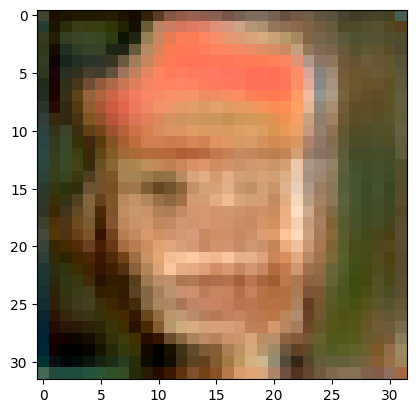

Resolution: 32*32  D_Loss: 0.1216  G_Loss: 5.4750  Alpha: 0.9339:   1%|          | 6319/599999 [3:14:28<374:53:00,  2.27s/it]

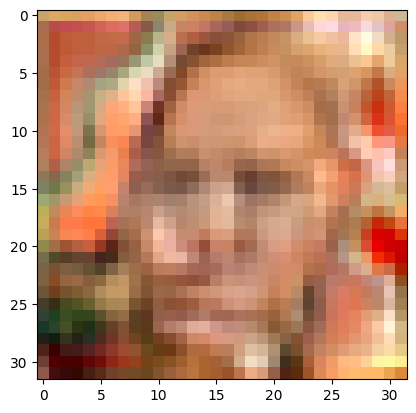

Resolution: 32*32  D_Loss: 0.1451  G_Loss: 4.9499  Alpha: 0.9445:   1%|          | 6359/599999 [3:15:59<374:27:41,  2.27s/it]

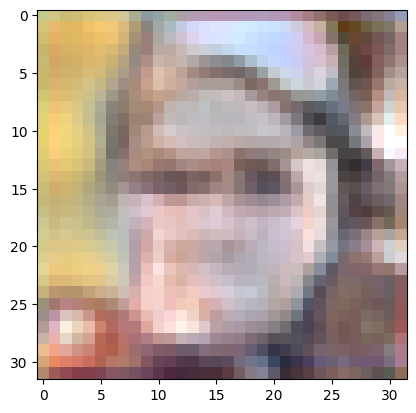

Resolution: 32*32  D_Loss: 0.1122  G_Loss: 4.6945  Alpha: 0.9552:   1%|          | 6399/599999 [3:17:30<375:12:38,  2.28s/it]

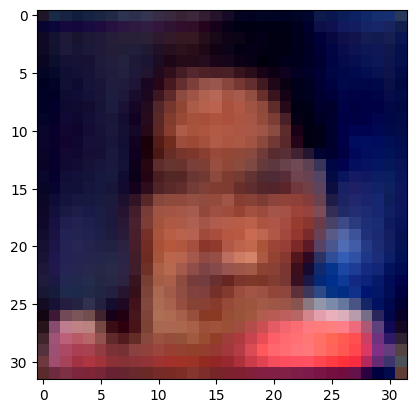

Resolution: 32*32  D_Loss: 0.5577  G_Loss: 8.3221  Alpha: 0.9659:   1%|          | 6439/599999 [3:19:01<374:31:33,  2.27s/it]

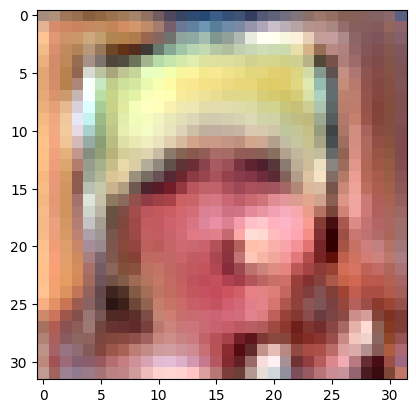

Resolution: 32*32  D_Loss: 0.0959  G_Loss: 4.7939  Alpha: 0.9765:   1%|          | 6479/599999 [3:20:33<374:22:11,  2.27s/it]

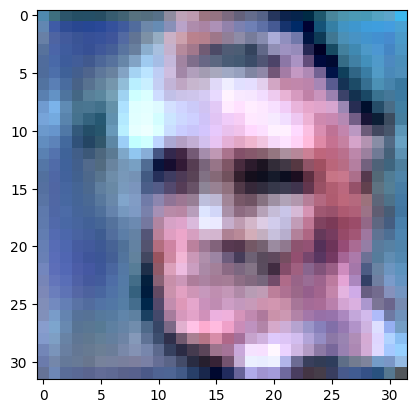

Resolution: 32*32  D_Loss: 0.1292  G_Loss: 6.5397  Alpha: 0.9872:   1%|          | 6519/599999 [3:22:04<373:34:53,  2.27s/it]

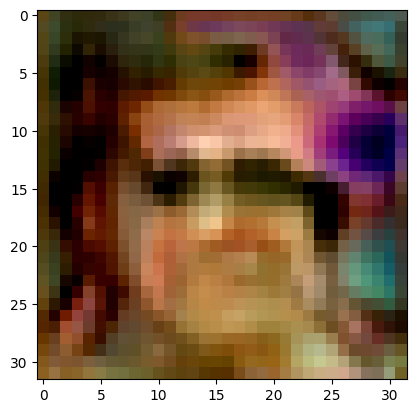

Resolution: 32*32  D_Loss: 0.1959  G_Loss: 4.6039  Alpha: 0.9979:   1%|          | 6559/599999 [3:23:35<374:24:36,  2.27s/it]

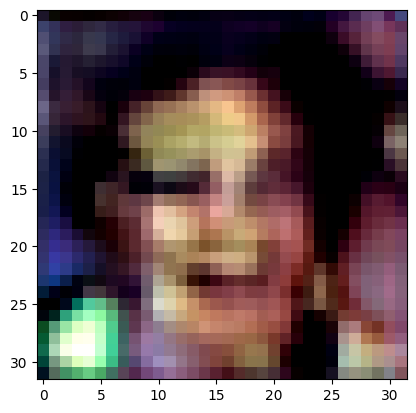

Resolution: 64*64  D_Loss: 0.2769  G_Loss: 3.3259  Alpha: 0.0041:   1%|          | 6599/599999 [3:29:29<1746:19:45, 10.59s/it]

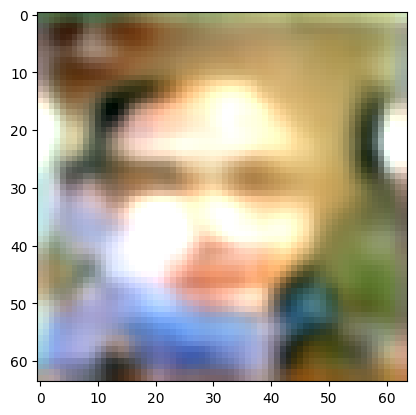

Resolution: 64*64  D_Loss: 0.0838  G_Loss: 6.0613  Alpha: 0.0095:   1%|          | 6639/599999 [3:36:34<1747:18:12, 10.60s/it]

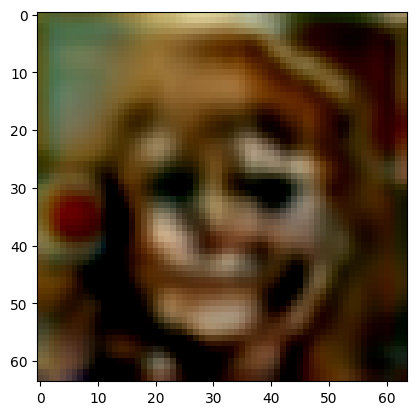

Resolution: 64*64  D_Loss: 0.9327  G_Loss: 2.9143  Alpha: 0.0148:   1%|          | 6679/599999 [3:43:38<1747:50:55, 10.61s/it]

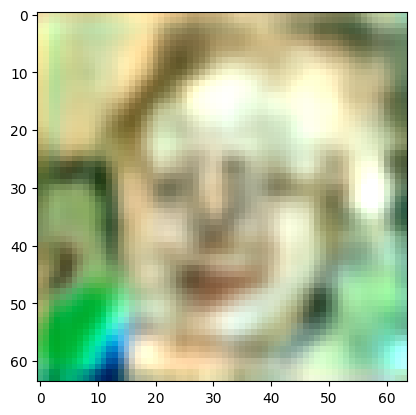

Resolution: 64*64  D_Loss: 0.1577  G_Loss: 4.8018  Alpha: 0.0201:   1%|          | 6719/599999 [3:50:42<1742:17:52, 10.57s/it]

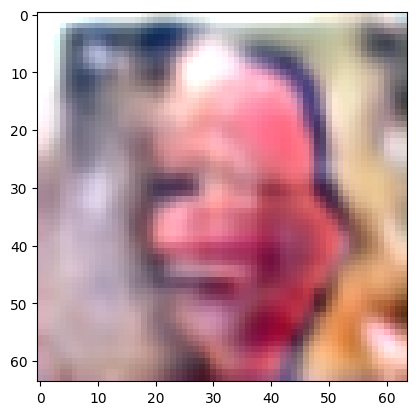

Resolution: 64*64  D_Loss: 0.2853  G_Loss: 5.5018  Alpha: 0.0255:   1%|          | 6759/599999 [3:57:46<1746:04:13, 10.60s/it]

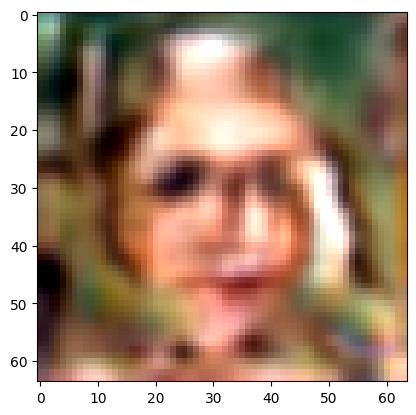

Resolution: 64*64  D_Loss: 0.3022  G_Loss: 3.6182  Alpha: 0.0308:   1%|          | 6799/599999 [4:04:50<1743:49:03, 10.58s/it]

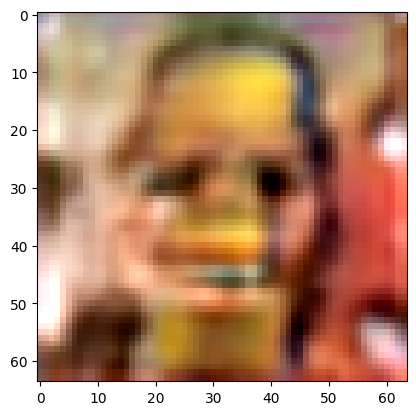

Resolution: 64*64  D_Loss: 0.1742  G_Loss: 4.0067  Alpha: 0.0361:   1%|          | 6839/599999 [4:11:53<1740:04:56, 10.56s/it]

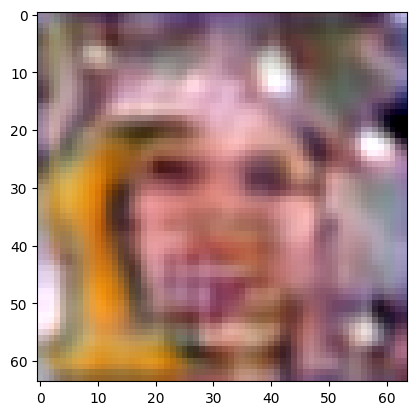

Resolution: 64*64  D_Loss: 0.2609  G_Loss: 4.1761  Alpha: 0.0415:   1%|          | 6879/599999 [4:18:56<1742:54:56, 10.58s/it]

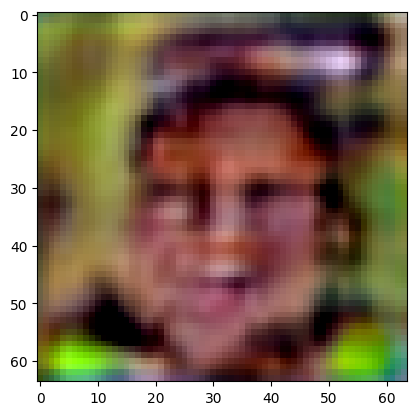

Resolution: 64*64  D_Loss: 0.2252  G_Loss: 4.7693  Alpha: 0.0468:   1%|          | 6919/599999 [4:26:00<1745:41:29, 10.60s/it]

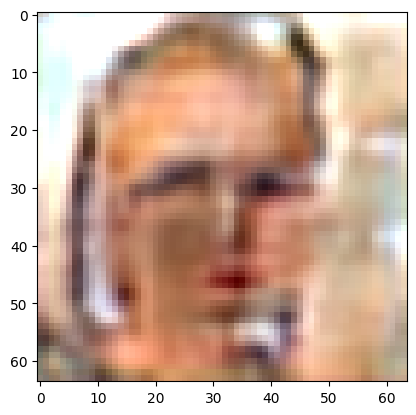

Resolution: 64*64  D_Loss: 0.5084  G_Loss: 6.8440  Alpha: 0.0521:   1%|          | 6959/599999 [4:33:04<1746:24:02, 10.60s/it]

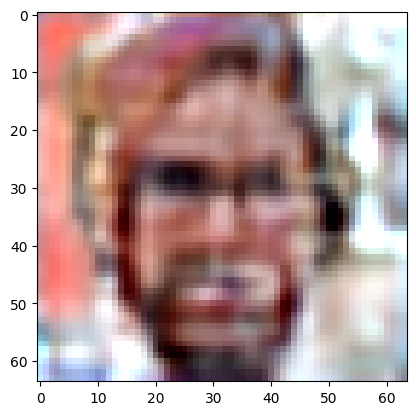

Resolution: 64*64  D_Loss: 0.1214  G_Loss: 3.7685  Alpha: 0.0575:   1%|          | 6999/599999 [4:40:13<2020:24:13, 12.27s/it]

Iteration 6999 successfully saved.


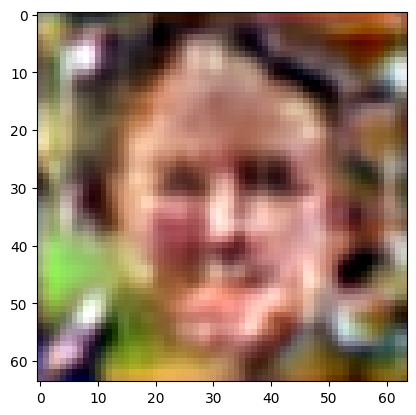

Resolution: 64*64  D_Loss: 0.1642  G_Loss: 3.5070  Alpha: 0.0628:   1%|          | 7039/599999 [4:47:13<1746:46:29, 10.61s/it]

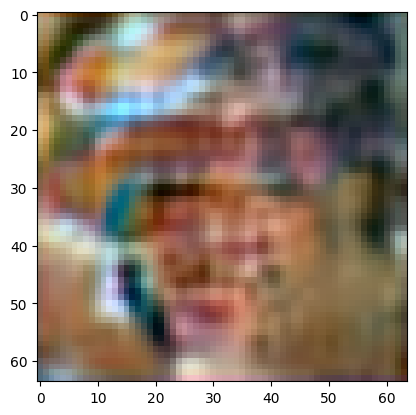

Resolution: 64*64  D_Loss: 0.4682  G_Loss: 4.2185  Alpha: 0.0681:   1%|          | 7079/599999 [4:54:17<1741:38:48, 10.57s/it]

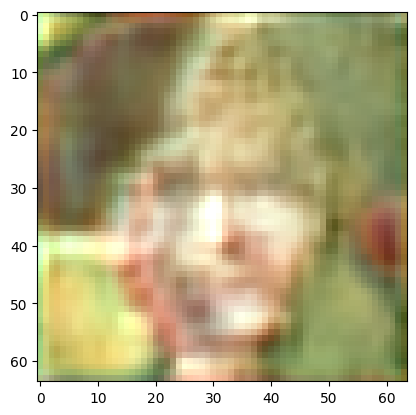

Resolution: 64*64  D_Loss: 0.1663  G_Loss: 3.6991  Alpha: 0.0735:   1%|          | 7119/599999 [5:01:21<1743:44:02, 10.59s/it]

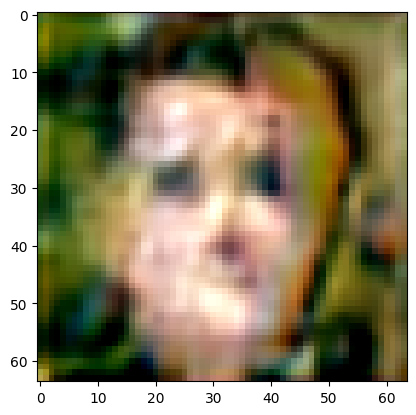

Resolution: 64*64  D_Loss: 0.1497  G_Loss: 3.7576  Alpha: 0.0788:   1%|          | 7159/599999 [5:08:25<1745:21:18, 10.60s/it]

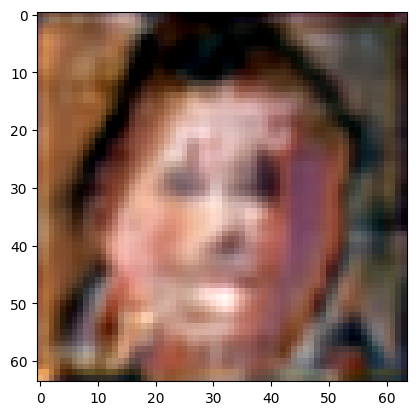

Resolution: 64*64  D_Loss: 0.2569  G_Loss: 3.1910  Alpha: 0.0841:   1%|          | 7199/599999 [5:15:28<1742:06:01, 10.58s/it]

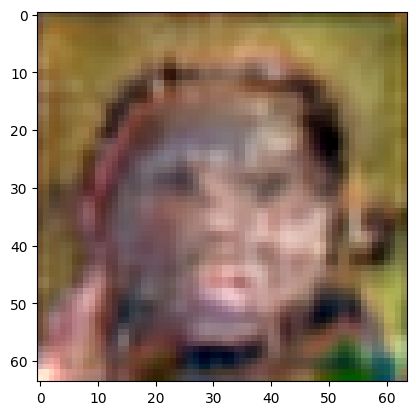

Resolution: 64*64  D_Loss: 0.1365  G_Loss: 4.1832  Alpha: 0.0895:   1%|          | 7239/599999 [5:22:32<1745:13:58, 10.60s/it]

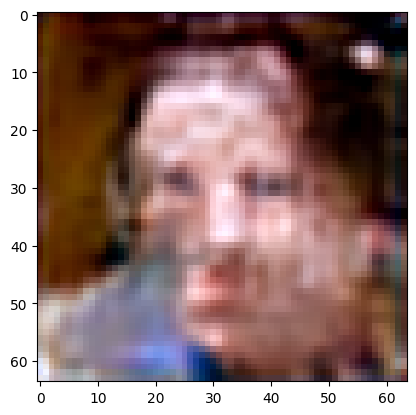

Resolution: 64*64  D_Loss: 0.0960  G_Loss: 5.4941  Alpha: 0.0948:   1%|          | 7279/599999 [5:29:36<1747:06:56, 10.61s/it]

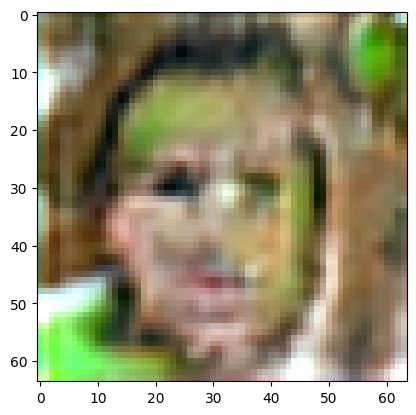

Resolution: 64*64  D_Loss: 0.1481  G_Loss: 4.0164  Alpha: 0.1001:   1%|          | 7319/599999 [5:36:40<1741:33:25, 10.58s/it]

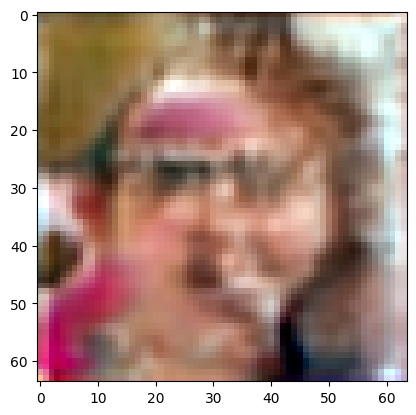

Resolution: 64*64  D_Loss: 0.2801  G_Loss: 6.9556  Alpha: 0.1055:   1%|          | 7359/599999 [5:43:45<1742:21:00, 10.58s/it]

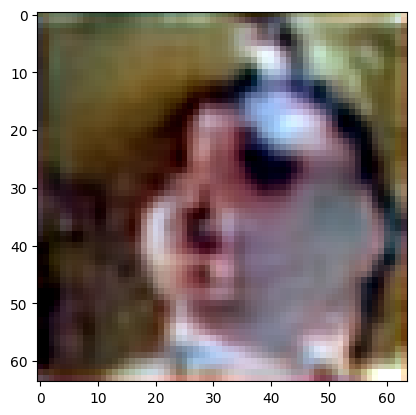

Resolution: 64*64  D_Loss: 0.0964  G_Loss: 4.9580  Alpha: 0.1108:   1%|          | 7399/599999 [5:50:48<1741:57:41, 10.58s/it]

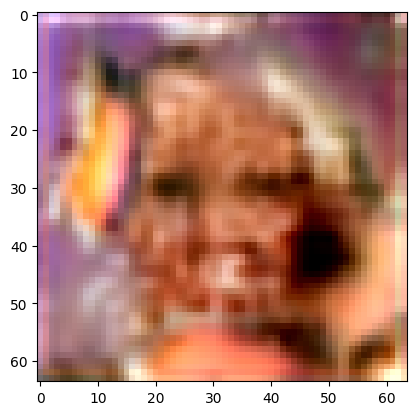

Resolution: 64*64  D_Loss: 0.1249  G_Loss: 5.2212  Alpha: 0.1161:   1%|          | 7439/599999 [5:57:52<1740:32:45, 10.57s/it]

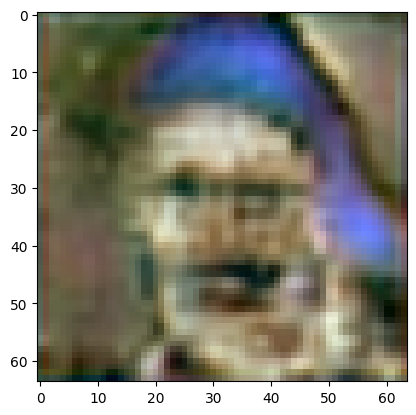

Resolution: 64*64  D_Loss: 0.1260  G_Loss: 5.9180  Alpha: 0.1215:   1%|          | 7479/599999 [6:04:55<1744:40:05, 10.60s/it]

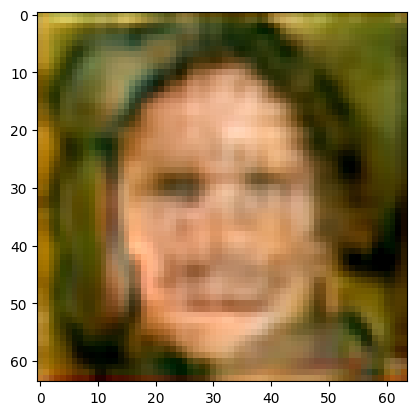

Resolution: 64*64  D_Loss: 0.0635  G_Loss: 5.1740  Alpha: 0.1268:   1%|▏         | 7519/599999 [6:11:59<1744:19:39, 10.60s/it]

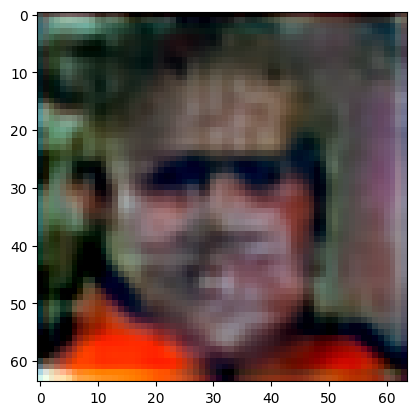

Resolution: 64*64  D_Loss: 0.2161  G_Loss: 3.9726  Alpha: 0.1321:   1%|▏         | 7559/599999 [6:19:03<1739:57:08, 10.57s/it]

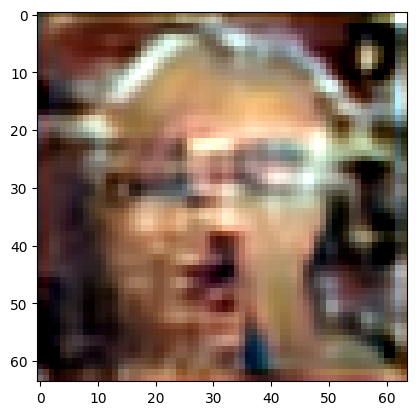

Resolution: 64*64  D_Loss: 0.2552  G_Loss: 4.9099  Alpha: 0.1375:   1%|▏         | 7599/599999 [6:26:07<1740:19:54, 10.58s/it]

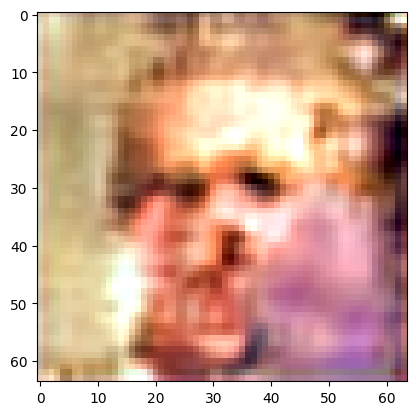

Resolution: 64*64  D_Loss: 0.4407  G_Loss: 5.0998  Alpha: 0.1428:   1%|▏         | 7639/599999 [6:33:11<1742:41:13, 10.59s/it]

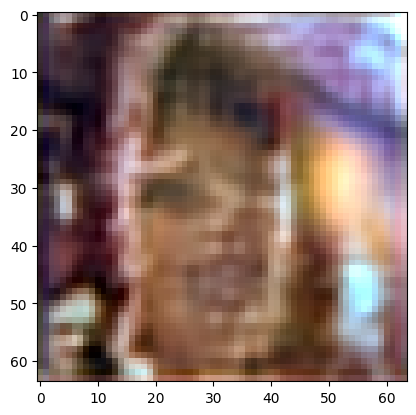

Resolution: 64*64  D_Loss: 0.0395  G_Loss: 4.5444  Alpha: 0.1481:   1%|▏         | 7679/599999 [6:40:15<1744:11:44, 10.60s/it]

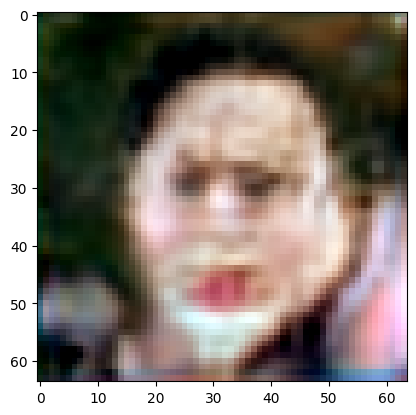

Resolution: 64*64  D_Loss: 0.0898  G_Loss: 4.0765  Alpha: 0.1535:   1%|▏         | 7719/599999 [6:47:19<1741:15:59, 10.58s/it]

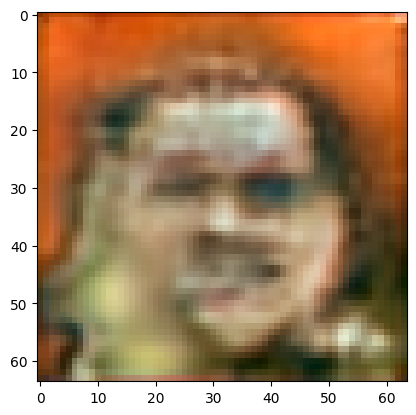

Resolution: 64*64  D_Loss: 0.3139  G_Loss: 4.7771  Alpha: 0.1588:   1%|▏         | 7759/599999 [6:54:22<1743:04:16, 10.60s/it]

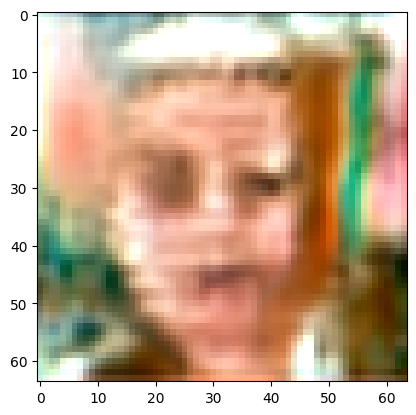

Resolution: 64*64  D_Loss: 0.4263  G_Loss: 7.6236  Alpha: 0.1641:   1%|▏         | 7799/599999 [7:01:26<1736:38:54, 10.56s/it]

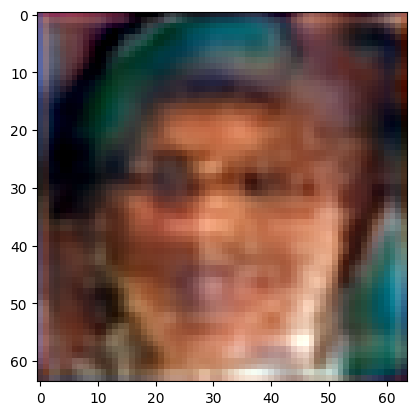

Resolution: 64*64  D_Loss: 0.8164  G_Loss: 8.4954  Alpha: 0.1695:   1%|▏         | 7839/599999 [7:08:30<1743:41:47, 10.60s/it]

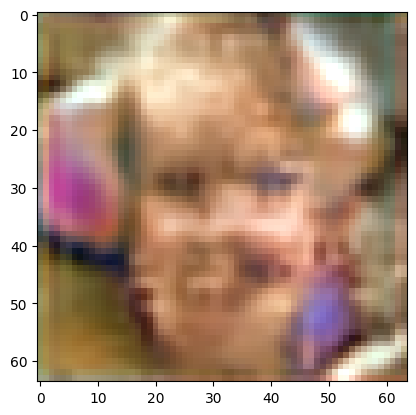

Resolution: 64*64  D_Loss: 0.2919  G_Loss: 4.1470  Alpha: 0.1748:   1%|▏         | 7879/599999 [7:15:33<1742:37:52, 10.59s/it]

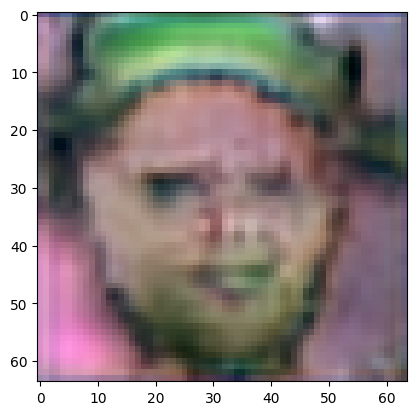

Resolution: 64*64  D_Loss: 0.1484  G_Loss: 4.0311  Alpha: 0.1801:   1%|▏         | 7919/599999 [7:22:37<1741:11:41, 10.59s/it]

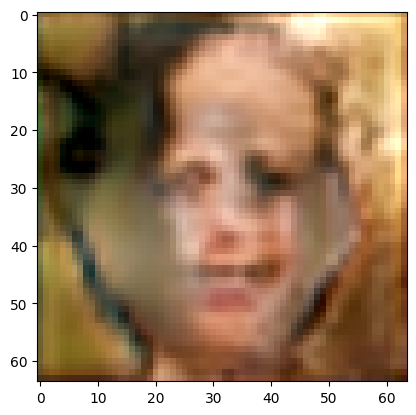

Resolution: 64*64  D_Loss: 0.2433  G_Loss: 4.3094  Alpha: 0.1841:   1%|▏         | 7949/599999 [7:27:55<1744:22:30, 10.61s/it]

In [ ]:

import os
os.environ['CUDA_VISIBLE_DEVICES']='1, 2'
n_gpu             = 1
device            = torch.device('cuda:0')

learning_rate     = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
batch_size_1gpu   = {4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16}
mini_batch_size_1 = 8
batch_size        = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
mini_batch_size   = 8
batch_size_4gpus  = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}
mini_batch_size_4 = 16
batch_size_8gpus  = {4: 512, 8: 256, 16: 128, 32: 64}
mini_batch_size_8 = 32
n_fc              = 8
dim_latent        = 512
dim_input         = 4
n_sample          = 120000
DGR               = 1
n_show_loss       = 40
step              = 1 # Train from (8 * 8)
max_step          = 8 # Maximum step (8 for 1024^2)
style_mixing      = [] # Waiting to implement
image_folder_path = './dataset/'
save_folder_path  = '/kaggle/working/'

low_steps         = [0, 1, 2]
# style_mixing    += low_steps
mid_steps         = [3, 4, 5]
# style_mixing    += mid_steps
hig_steps         = [6, 7, 8]
# style_mixing    += hig_steps

# Used to continue training from last checkpoint
startpoint        = 0
used_sample       = 0
alpha             = 0


is_train          = True


# True for start from saved model
# False for retrain from the very beginning
is_continue       = True
d_losses          = [float('inf')]
g_losses          = [float('inf')]
inputs, outputs = [], []

def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def reset_LR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul
        
# Gain sample
def gain_sample(dataset, batch_size, image_size=4):
    transform = transforms.Compose([
            transforms.Resize(image_size),          # Resize to the same size
            transforms.CenterCrop(image_size),      # Crop to get square area
            transforms.RandomHorizontalFlip(),      # Increase number of samples
            transforms.ToTensor(),            
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

    dataset.transform = transform
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=8)

    return loader

def imshow(tensor, i):
    grid = tensor[0]
    grid.clamp_(-1, 1).add_(1).div_(2)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    img.save(f'{save_folder_path}sample-iter{i}.png')
    plt.imshow(img)
    plt.show()
    
# Train function
def train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint=0, used_sample=0,
         d_losses = [], g_losses = [], alpha=0):
    
    resolution  = 4 * 2 ** step
    
    origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
    data_loader = iter(origin_loader)
    
    reset_LR(g_optim, learning_rate.get(resolution, 0.001))
    reset_LR(d_optim, learning_rate.get(resolution, 0.001))
    
    progress_bar = tqdm(range(startpoint + 1, n_sample * 5))
    # Train
    for i in progress_bar:
        alpha = min(1, alpha + batch_size.get(resolution, mini_batch_size) / (n_sample * 2))
        
        if used_sample > n_sample * 2 and step < max_step: 
            step += 1
            
            alpha = 0
            used_sample = 0
            
            resolution = 4 * 2 ** step
            
            # Avoid possble memory leak
            del origin_loader
            del data_loader
            
            # Change batch size
            origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
            data_loader = iter(origin_loader)
            reset_LR(g_optim, learning_rate.get(resolution, 0.001))
            reset_LR(d_optim, learning_rate.get(resolution, 0.001))
            
        
        try:
            # Try to read next image
            real_image, label = next(data_loader)

        except (OSError, StopIteration):
            # Dataset exhausted, train from the first image
            data_loader = iter(origin_loader)
            real_image, label = next(data_loader)
        
        # Count used sample
        used_sample += real_image.shape[0]
        
        # Send image to GPU
        real_image = real_image.to(device)
        
        # D Module ---
        # Train discriminator first
        discriminator.zero_grad()
        set_grad_flag(discriminator, True)
        set_grad_flag(generator, False)
        
        # Real image predict & backward
        # We only implement non-saturating loss with R1 regularization loss
        real_image.requires_grad = True
        if n_gpu > 1:
            real_predict = nn.parallel.data_parallel(discriminator, (real_image, step, alpha), range(n_gpu))
        else:
            real_predict = discriminator(real_image, step, alpha)
        real_predict = nn.functional.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = torch.autograd.grad(outputs=real_predict.sum(), inputs=real_image, create_graph=True)[0]
        grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty_real = 10 / 2 * grad_penalty_real
        grad_penalty_real.backward()
        
        # Generate latent code
        latent_w1 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        latent_w2 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]

        noise_1 = []
        noise_2 = []
        for m in range(step + 1):
            size = 4 * 2 ** m # Due to the upsampling, size of noise will grow
            noise_1.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
            noise_2.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
        
        # Generate fake image & backward
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w1, step, alpha, noise_1), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else:
            fake_image = generator(latent_w1, step, alpha, noise_1)
            fake_predict = discriminator(fake_image, step, alpha)

        fake_predict = nn.functional.softplus(fake_predict).mean()
        fake_predict.backward()
        
        if i % n_show_loss == 0:
            d_losses.append((real_predict + fake_predict).item())
        
        # D optimizer step
        d_optim.step()
        
        # Avoid possible memory leak
        del grad_penalty_real, grad_real, fake_predict, real_predict, fake_image, real_image, latent_w1
                   
        # G module ---
        if i % DGR != 0: continue
        # Due to DGR, train generator
        generator.zero_grad()
        set_grad_flag(discriminator, False)
        set_grad_flag(generator, True)
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w2, step, alpha, noise_2), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else: 
            fake_image = generator(latent_w2, step, alpha, noise_2)
            fake_predict = discriminator(fake_image, step, alpha)
        fake_predict = nn.functional.softplus(-fake_predict).mean()
        fake_predict.backward()
        g_optim.step()

        if i % n_show_loss == 0:
            g_losses.append(fake_predict.item())
            imshow(fake_image.data.cpu(), i)
            
        # Avoid possible memory leak
        del fake_predict, fake_image, latent_w2
        
        if (i + 1) % 1000 == 0:
            # Save the model every 1000 iterations
            torch.save({
                'generator'    : generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optim'      : g_optim.state_dict(),
                'd_optim'      : d_optim.state_dict(),
                'parameters'   : (step, i, used_sample, alpha),
                'd_losses'     : d_losses,
                'g_losses'     : g_losses
            }, '/kaggle/working/trained.pth')
            print(f'Iteration {i} successfully saved.')
        
        progress_bar.set_description((f'Resolution: {resolution}*{resolution}  D_Loss: {d_losses[-1]:.4f}  G_Loss: {g_losses[-1]:.4f}  Alpha: {alpha:.4f}'))
        
    return d_losses, g_losses



generator      = StyleBased_Generator(n_fc, dim_latent, dim_input).to(device)
discriminator  = Discriminator().to(device)
g_optim        = optim.Adam([{
    'params': generator.convs.parameters(),
    'lr'    : 0.001
}, {
    'params': generator.to_rgbs.parameters(),
    'lr'    : 0.001
}], lr=0.001, betas=(0.0, 0.99))
g_optim.add_param_group({
    'params': generator.fcs.parameters(),
    'lr'    : 0.001 * 0.01,
    'mul'   : 0.01
})
d_optim        = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))
dataset        = datasets.ImageFolder('/kaggle/input/ffhq-face-data-set')

if is_continue:
    if os.path.exists('checkpoint/trained.pth'):
        # Load data from last checkpoint
        print('Loading pre-trained model...')
        checkpoint = torch.load('checkpoint/trained.pth')
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optim.load_state_dict(checkpoint['g_optim'])
        d_optim.load_state_dict(checkpoint['d_optim'])
        step, startpoint, used_sample, alpha = checkpoint['parameters']
        d_losses = checkpoint.get('d_losses', [float('inf')])
        g_losses = checkpoint.get('g_losses', [float('inf')])
    else:
        print('No pre-trained model detected, restart training...')
        
if is_train:
    generator.train()
    discriminator.train()    
    d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint, used_sample, d_losses, g_losses, alpha)
else:
    pass